# Introduction

This notebook contains all the details of the models' training which have been included in the final report.

## Library Loading

Below, we will load the relevant libraries and set some helper functions for plotting/random seed setting.

In [1]:
from   copy                                       import copy
## note that there are many packages to run the DTW in python. Make sure to install the right one (`dtw-python`)
# pip install dtw-python
from   dtw                                        import *
from   joblib                                     import Parallel, delayed
from   functools                                  import wraps
import lightgbm                                   as     lgb
import matplotlib.pyplot                          as     plt
import numpy                                      as     np
import os
import pandas                                     as     pd
import pmdarima                                   as     pm
import random
import scipy
from   scipy                                      import stats, optimize
from   scipy.special                              import expit, logit, logsumexp
import seaborn                                    as     sns
from   sklearn.cluster                            import HDBSCAN
from   sklearn.model_selection                    import GridSearchCV
from   sklearn.preprocessing                      import StandardScaler
from   statsmodels.tsa.exponential_smoothing.ets  import ETSModel
import tensorflow                                 as     tf
# deactivate training via GPU to parallelize on GPFlow
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.config.set_visible_devices([], 'GPU')
from   tensorflow.keras.callbacks                 import EarlyStopping
from   tensorflow.keras.layers                    import Input, LSTM, Dense, Reshape, \
                                                         Convolution1D, MaxPool1D, Lambda, GRU
from   tensorflow.keras.models                    import Sequential
from   tqdm                                       import tqdm
from   tensorflow.keras.utils                     import plot_model
import gpflow
from   gpflow.optimizers                          import Scipy
from   gpflow.utilities                           import positive, print_summary
import tensorflow_probability                     as tfp
from   tensorflow_probability                     import bijectors as tfb
import warnings



# set seed for reproducibility
def set_seeds(seed=42):
    """
    This function sets the seeds to be used by the Tensorflow backend
    """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    tf.config.threading.set_inter_op_parallelism_threads(1)
    
# set the seeds and check the physical devices
set_seeds()

# set plotting parameters
plt.rcParams["figure.dpi"] = 150
plt.rcParams["figure.figsize"] = (8,4)
plt.style.use("bmh")
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["lines.linewidth"] = 1.0
# Extra code to use latex
plt.rcParams["text.usetex"]=True
plt.rc('text.latex', preamble=r'\usepackage{amsfonts}')
plt.rcParams["font.family"] = "cm"

# Set the Output Folder
img_output_folder = "../img_smooth"
os.makedirs(img_output_folder, exist_ok=True)

model_output_folder = "../models_smooth"
os.makedirs(model_output_folder, exist_ok=True)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



## Data Preparation and Visualization

In this section, we will prepare the data for training.<br>
First, we load the data set.

In [2]:
# load the data
df = pd.read_csv("../data/google_trends_data.csv", parse_dates=True, index_col=0).astype(float).loc[:"2022-12-15",:].iloc[-60:,:].rolling(4).mean().dropna()/100.0
# clip it
df = df.clip(1e-4, 1.0-1e-4)

# Modify the names of the columns
df.columns = [el.replace("/", "") for el in list(df.columns)]

df.index.freq = "W"
df.head()

,AB Testing,AI for Social Good,AI in Education,AI in Gaming,AI in Healthcare,ARIMA,Ablation,Accuracy,Action,Action Recognition,...,User Behavior Analytics,Variational Autoencoders,Video Analysis,Virtual Reality and AI,Weight,Weighted Sum,Width,Word2Vec,XGBoost,t-SNE
date,,,,,,,,,,,,,,,,,,,,,
2021-11-14,0.4025,0.0400,0.0825,0.1250,0.1925,0.6550,0.2600,0.5625,0.8600,0.3100,...,0.0850,0.1100,0.610,0.0150,0.7350,0.1450,0.2175,0.4475,0.5475,0.3175
2021-11-21,0.3825,0.0400,0.0825,0.1075,0.1650,0.6350,0.2450,0.5600,0.8225,0.3200,...,0.1100,0.1200,0.575,0.0075,0.7175,0.1475,0.2150,0.4425,0.5375,0.3025
2021-11-28,0.3900,0.0425,0.0775,0.0625,0.1875,0.6200,0.2400,0.5800,0.8250,0.3050,...,0.1150,0.1500,0.595,0.0075,0.7150,0.1450,0.2125,0.4525,0.5575,0.3075
2021-12-05,0.4075,0.0225,0.0800,0.0625,0.1925,0.6125,0.2325,0.5825,0.8225,0.3125,...,0.0925,0.1675,0.600,0.0200,0.7075,0.1675,0.2150,0.4475,0.5875,0.3300
2021-12-12,0.4350,0.0125,0.0725,0.0650,0.2050,0.6175,0.2300,0.6325,0.8100,0.2950,...,0.0875,0.1600,0.590,0.0275,0.7250,0.1575,0.2125,0.4450,0.6050,0.3525


Next, we split the data set into training set and test set (last 16 weeks of the set), and apply the logit transformation.

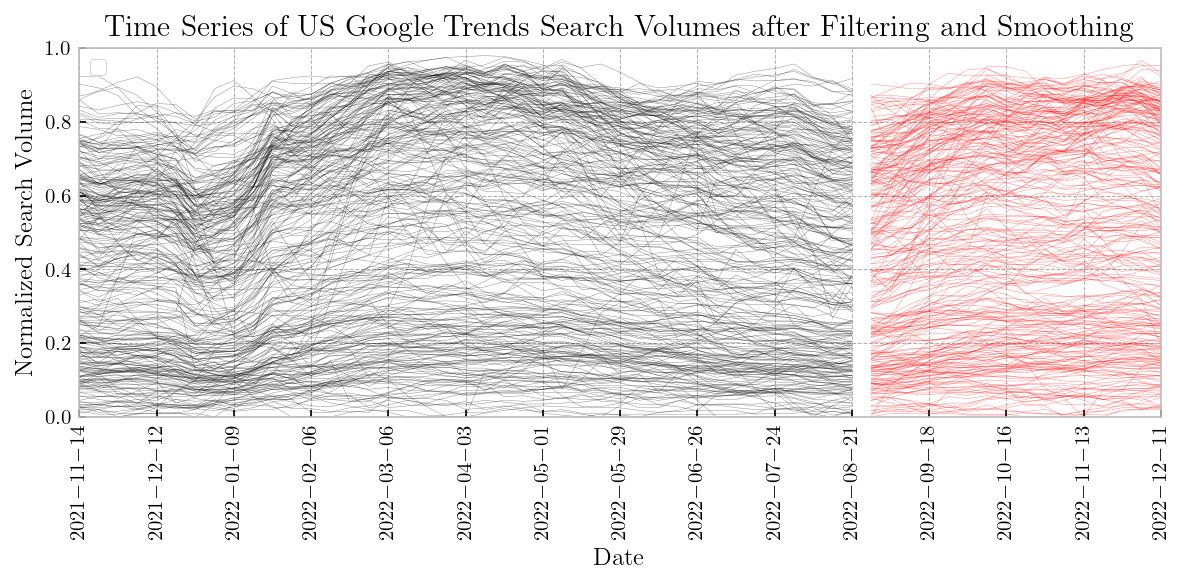

In [3]:
# Set the number of weeks for test set
n_test = 16
df_train, df_test = df.iloc[:-n_test,:].copy() , df.iloc[-n_test:,:].copy()
X_train, X_test = df_train.values, df_test.values

# Number of input/test steps
n_in = n_test
n_out = n_test

# Plot training and test set
plt.plot(df_train.iloc[:,0], color="k", alpha=0.5, lw=0.2, label="training");
plt.plot(df_test.iloc[:,0], color="r", alpha=0.5, lw=0.2, label="test");
plt.plot(df_train.iloc[:,1:], color="k", alpha=0.5, lw=0.2);
plt.plot(df_test.iloc[:,1:], color="r", alpha=0.5, lw=0.2);

plt.ylim([0,1])
plt.xlim([df.index[0], df.index[-1]])
plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
plt.xlabel("Date")
plt.ylabel("Normalized Search Volume")
plt.title("Time Series of US Google Trends Search Volumes after Filtering and Smoothing")
plt.legend("")
plt.xticks(df.index[::4], rotation=90)
plt.tight_layout()
plt.savefig(os.path.join(img_output_folder,f"fig_{'1'.zfill(5)}.pdf"))

# apply the transformation to the data set.
df_train, X_train = logit(df_train), logit(X_train)

# Metrics & Helper Functions

We define the metrics: Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE). <br>

In [4]:
def MAE(y_pred, y_true):
    """
    Calculates the Mean Absolute Error between ground truth y_true and prediction y_pred
    """
    return np.mean(np.abs(y_true-y_pred))

def MAPE(y_pred, y_true):
    """
    Calculates the Mean Absolute Error between ground truth y_true and prediction y_pred
    """
    return np.mean(np.abs(y_true-y_pred)/np.abs(y_true))

 We also implement two helper functions: <br>
 * `clipOutputs`: which forces the output to fall in the (0,1) interval. <br>
 * `printResults`: which instead prints the results. <br>
 * `plotPrediction`: a function to plot the predictions of the used models.

In [5]:
def clipOutputs(forecast, ub, lb, n_digits = 6):
    forecast, ub, lb = np.round(forecast, n_digits), np.round(ub, n_digits), np.round(lb, n_digits)
    forecast = np.clip(forecast,0,1)
    ub = np.clip(ub,0,1)
    lb = np.clip(lb,0,1)
    return forecast, ub, lb

def printResults(df_pred, df_test, df_ub, df_lb, namestring="baseline"):
    """
    Helper Function to print the results
    """
    print(f"The MAE value for the {namestring} is : {MAE(df_pred.values,df_test.values)}")
    print(f"The MAPE value for the {namestring} is : {MAPE(df_pred.values,df_test.values)}")
    print(f"The average confidence {namestring} for the baseline is: {np.mean(df_ub.values-df_lb.values)}")


def plotPrediction(pred, ub, lb, k=0):
    # Plot the ground truth
    scipy.special.expit(df_train.iloc[:,k]).plot(label="training")
    df_test.iloc[:,k].plot(label="test")
    
    # Get the values ready
    pred = pred.iloc[:,k]
    ub = ub.values[:,k]
    lb = lb.values[:,k]
    
    # Plot
    pred.plot(label="prediction")
    plt.fill_between(pred.index, ub, lb, 
                     color="gray", alpha=0.3, label="95\% PI")
    plt.legend(loc='upper left')
    plt.ylabel("Normalized Search Volume")
    plt.ylim([0,plt.gca().get_ylim()[1]])
    plt.title(df.columns[k])

# Methods

## Naive Forecast
In this section, we implement the naive forecast, forecasting the last observed time series value.

In [6]:
def naive_forecast(timeseries, n_periods=n_test, predint=0.95):
    """
    Returns the naive forecast with normally errors
    (depending on BIC)
    Inputs:
    - timeseries: an numpy array indicating the time series
    - n_periods: the number of forecast periods
    - predint: the confidence interval for the errors (the confidence intervals assume the growth according to a normal model)
    """
    # Calculate future forecast
    forecast = [timeseries[-1]]*n_periods
    forecast = np.array(forecast)

    # Calculate the errors
    errors = np.diff(timeseries)

    # Calculate get the standard deviation from the errors
    err_std = np.std(errors)
    
    # Get the multiplier for the errors
    err_std = err_std * stats.norm.ppf(0.5+predint*0.5) * np.arange(1,n_test+1)**0.5
    
    # Calculate upper and lower bounds
    ub, lb = forecast+err_std, forecast-err_std


    # return forecast and bounds
    forecast = scipy.special.expit(forecast)
    ub = scipy.special.expit(ub)
    lb = scipy.special.expit(lb)

    return forecast, ub, lb

We now apply the baseline model to all the time series and obtain the predictions.

In [7]:
# obtain predictions, upper and lower bounds for the baseline model
pred_baseline, ub_baseline, lb_baseline = zip(*Parallel(-1)(delayed(naive_forecast)(df_train.iloc[:,i].values.astype(float)) for i in tqdm(range(df.shape[1]))))
pred_baseline, ub_baseline, lb_baseline = zip(*Parallel(-1)(delayed(clipOutputs)(pred_baseline[i], ub_baseline[i], lb_baseline[i]) for i in tqdm(range(df.shape[1]))))
df_pred_baseline, df_ub_baseline, df_lb_baseline = df_test.copy(), df_test.copy(), df_test.copy()

# transfer the output to Pandas Data Frames
df_pred_baseline[df.columns] = np.array(pred_baseline).T
df_ub_baseline[df.columns] = np.array(ub_baseline).T
df_lb_baseline[df.columns] = np.array(lb_baseline).T


  0%|          | 0/281 [00:00<?, ?it/s]

100%|██████████| 281/281 [00:00<00:00, 4700.41it/s]


In [8]:
printResults(df_pred_baseline, df_test, df_ub_baseline, df_lb_baseline, namestring="baseline")

The MAE value for the baseline is : 0.0759147909252669
The MAPE value for the baseline is : 0.6689218002756311
The average confidence baseline for the baseline is: 0.2772040725088968


We could plot the baseline result like below.

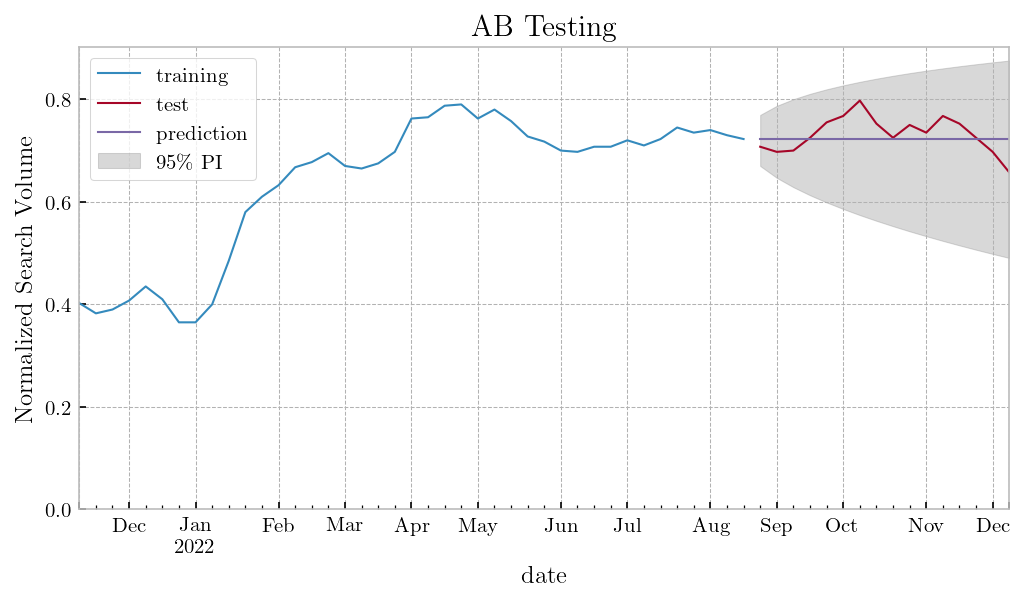

In [9]:
plotPrediction(df_pred_baseline, df_ub_baseline, df_lb_baseline)

## ARIMA

Here we define the wrapper to train the ARIMA model.

In [10]:
def arima_wrapper(timeseries, n_test=n_test, predint=0.95):
    """
    Wrapper for AUTO-ARIMA. This is used for parallel model training and returns
    Inputs:
    - timeseries : the time series to fit
    - n_test     : the horizon length to be used for testing
    - predint    : the confidence level
    """
    model = pm.auto_arima(timeseries, seasonal=True, max_p=10, max_q=10, max_d=3, 
                            information_criterion="bic", error_action="ignore",
                            max_order=44, maxiter=100, max_P=2, max_D=1, max_Q=2)
    

    # get the prediction and the confidence interval
    forecast, conf_int = model.predict(n_test, return_conf_int=True, alpha=1-predint)
    forecast = scipy.special.expit(forecast)
    conf_int = scipy.special.expit(conf_int)

    return model, forecast, conf_int[:,1], conf_int[:,0]

And we then train the automatic ARIMA model on all the time series in the data set. Everything is parallelized in order to achieve higher speed.

In [11]:
# Obtain the models and the predictions
models_arima, pred_arima, ub_arima, lb_arima = zip(*Parallel(-1)(delayed(arima_wrapper)
                                                                 (df_train.iloc[:,i].values.astype(float)) 
                                                                 for i in tqdm(range(df.shape[1]))))

# Clip in the interval
pred_arima, ub_arima, lb_arima = zip(*Parallel(-1)(delayed(clipOutputs)
                                                   (pred_arima[i], ub_arima[i], lb_arima[i]) 
                                                   for i in tqdm(range(df.shape[1]))))

# Cast to Pandas Data Frames
df_pred_arima, df_ub_arima, df_lb_arima = df_test.copy(), df_test.copy(), df_test.copy()

# transfer the output to Pandas Data Frames
df_pred_arima[df.columns] = np.array(pred_arima).T
df_ub_arima[df.columns] = np.array(ub_arima).T
df_lb_arima[df.columns] = np.array(lb_arima).T


100%|██████████| 281/281 [00:00<00:00, 5023.59it/s]


In [12]:
printResults(df_pred_arima, df_test, df_ub_arima, df_lb_arima, namestring="ARIMA")

The MAE value for the ARIMA is : 0.06636387144128114
The MAPE value for the ARIMA is : 0.753517313504651
The average confidence ARIMA for the baseline is: 0.26428962878113876


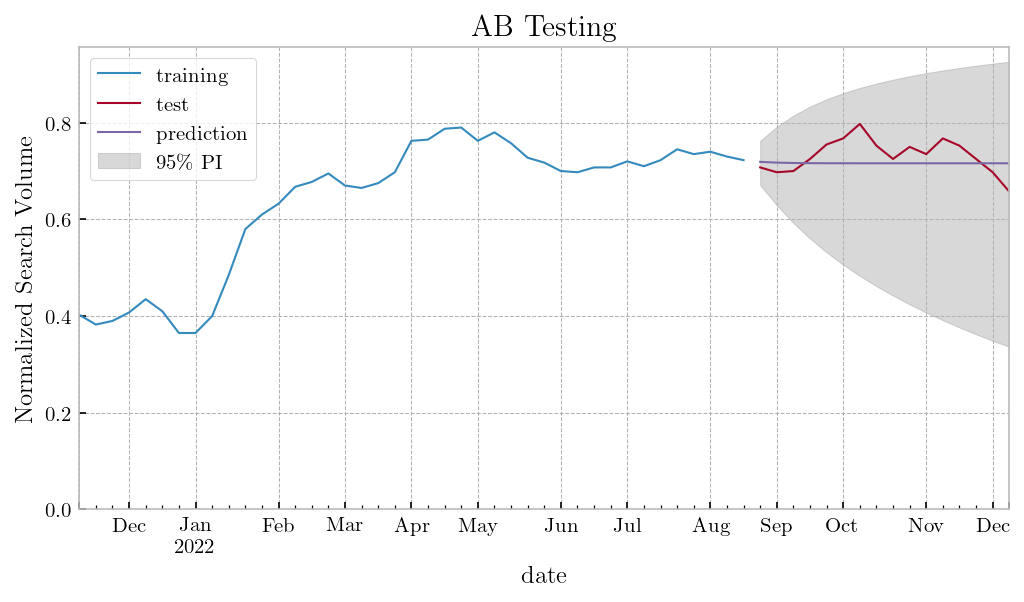

In [13]:
plotPrediction(df_pred_arima, df_ub_arima, df_lb_arima)

## Holt-Winters
Here we define the wrapper to train the Holt-Winters model and train the model on all time series.

In [14]:
def HoltWintersWrapper(timeseries, n_test=n_test, predint=0.95):
    """
    Wrapper for Holt-Winters. This is used for parallel model training and returns 
    - timeseries : the time series to fit
    - n_test     : the horizon length to be used for testing
    - predint    : the confidence level
    """
    # fit the model
    timeseries.index.freq = "W-SUN"
    model = ETSModel(timeseries, trend="add", initialization_method="estimated")
    model_results = model.fit(disp=False)

    # get the prediction
    prediction = model_results.get_prediction(start=df_test.index[0], end=df_test.index[-1])

    # get mean prediction and prediction interval
    pred_int = prediction.pred_int(alpha=1.0-predint)
    ub = pred_int.values[:,1]
    lb = pred_int.values[:,0]
    forecast = prediction.predicted_mean.values

    # get the prediction and the confidence interval
    forecast = scipy.special.expit(forecast)
    ub = scipy.special.expit(ub)
    lb = scipy.special.expit(lb)

    
    return model, model_results, forecast, ub, lb

In [15]:
# Obtain the models and the predictions
models_hw, models_res_hw, pred_hw, ub_hw, lb_hw = zip(*Parallel(-1)(delayed(HoltWintersWrapper)
                                                                 (df_train.iloc[:,i]) 
                                                                 for i in tqdm(range(df.shape[1]))))

# Clip in the interval
pred_hw, ub_hw, lb_hw = zip(*Parallel(-1)(delayed(clipOutputs)
                                                   (pred_hw[i], ub_hw[i], lb_hw[i]) 
                                                   for i in tqdm(range(df.shape[1]))))

# Cast to Pandas Data Frames
df_pred_hw, df_ub_hw, df_lb_hw = df_test.copy(), df_test.copy(), df_test.copy()

# Transfer the output to Pandas Data Frames
df_pred_hw[df.columns] = np.array(pred_hw).T
df_ub_hw[df.columns] = np.array(ub_hw).T
df_lb_hw[df.columns] = np.array(lb_hw).T


100%|██████████| 281/281 [00:00<00:00, 4719.74it/s]


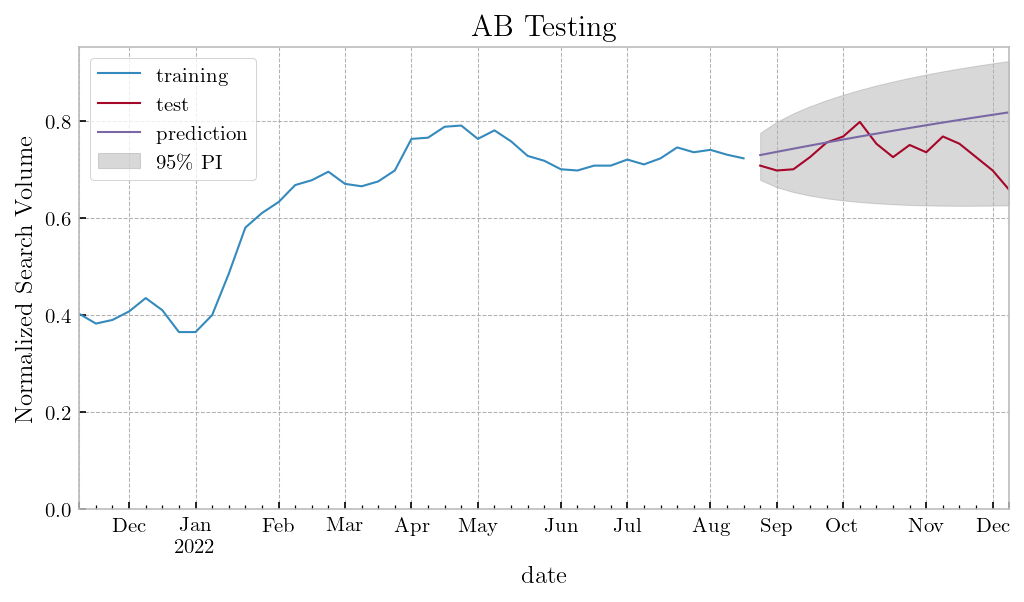

In [16]:
plotPrediction(df_pred_hw, df_ub_hw, df_lb_hw)

In [17]:
printResults(df_pred_hw, df_test, df_ub_hw, df_lb_hw, namestring="Holt-Winters")

The MAE value for the Holt-Winters is : 0.11144526134341638
The MAPE value for the Holt-Winters is : 0.6548831716285144
The average confidence Holt-Winters for the baseline is: 0.40869537544483986


## ML/DL Local Modeling
The ML/DL local modeling section covers a group of models which have been trained on a single time series each.

In [18]:
def chunkDataset(df, n_in=n_test, n_out=n_test):
    """
    Helper function used to chunk the data set.
    Inputs:
    - df   : the data frame to split.
    - n_in : the number of time steps to use as regressors.
    - n_test : the number of time steps to use as output.
    """
    
    # create the data set for the random forest regressor
    X_out = []
    y_out = []

    for j in range(df.shape[1]):
        for i in range(df.shape[0]-n_in-n_out+1):
            X_out.append(df.values[i:i+n_in,j])
            y_out.append(df.values[i+n_in:i+n_in+n_out,j])

    X_out = np.array(X_out)
    y_out = np.array(y_out)
    
    return X_out, y_out

In [19]:
# prepare the data set
X_train_rf, y_train_rf = zip(*[chunkDataset(df_train.iloc[:,[i]], n_in=n_in, n_out=n_test) for i in range(df_train.shape[1])])
X_train_rf = np.stack(X_train_rf, axis=0)
y_train_rf = np.stack(y_train_rf, axis=0)

### Local LightGBM
Train the LigthGBM model on each of the time series.

In [20]:
def optimize_lgbm(data_x, data_y, j, n_jobs = -1):
    """
    This function finds the best model for lightgbm and trains it on the data
    """
    gridParams = {
        'learning_rate': [0.001, 0.01, 0.1],
 #       'n_estimators': [100, 200, 400],
        'num_leaves': [20, 30, 40],
        'boosting_type' : ['gbdt'],
        'objective' : ['regression'],
        'random_state' : [42], 
        'reg_alpha' : [1,1.5],
        'reg_lambda' : [1,1.5],
        'force_row_wise': [True],
        'metric' : ["l1"],
        'verbose': [-100],
        }
    
    # instantiate a model
    lgbm = lgb.LGBMRegressor()

    # use 3-fold cross-validation for the parameters
    grid = GridSearchCV(lgbm, gridParams,  cv=3, n_jobs=n_jobs)

    # fit the grid search (only on the first input, to make it easier)
    grid.fit(data_x, data_y[:,0], eval_metric='l1')

    def paramsLightGBM(alpha=None):
        params = grid.best_params_
        params["objective"] = "quantile"
        params["alpha"] = alpha
        return params

    # create a list of datasets
    lgb_train = [lgb.Dataset(data_x[:,:], data_y[:,i]) for i in range(n_test)] 

    # Train the n_test models
    models_lgbm = [lgb.train(paramsLightGBM(0.5), lgb_train[i], num_boost_round=20) for i in range(n_test)]
    gbm_ub = [lgb.train(paramsLightGBM(0.95), lgb_train[i], num_boost_round=20) for i in range(n_test)]
    gbm_lb = [lgb.train(paramsLightGBM(0.05), lgb_train[i], num_boost_round=20) for i in range(n_test)]

    
    # Predict
    pred_lgbm = scipy.special.expit(np.array([models_lgbm[i].predict(df_train.values[-n_in:,[j]].T) for i in range(n_test)]))
    ub_lgbm = scipy.special.expit(np.array([gbm_ub[i].predict(df_train.values[-n_in:,[j]].T) for i in range(n_test)]))
    lb_lgbm = scipy.special.expit(np.array([gbm_lb[i].predict(df_train.values[-n_in:,[j]].T) for i in range(n_test)]))

    # Clip in correct range
    pred_lgbm, ub_lgbm, lb_lgbm = clipOutputs(pred_lgbm, ub_lgbm, lb_lgbm)

    return pred_lgbm, ub_lgbm, lb_lgbm

In [21]:
# Obtain the predictions and the prediction intervals from the lightGBM model.
local_lightgbmout = Parallel(n_jobs=-1)(delayed(optimize_lgbm)(X_train_rf[i], y_train_rf[i], i, n_jobs=1) for i in tqdm(range(len(X_train_rf))))
pred_locallightgbm, ub_locallightgbm, lb_locallightgbm  = zip(*local_lightgbmout) 
pred_locallightgbm = np.squeeze(np.stack(pred_locallightgbm, axis=1))
ub_locallightgbm = np.squeeze(np.stack(ub_locallightgbm, axis=1))
lb_locallightgbm = np.squeeze(np.stack(lb_locallightgbm, axis=1))

# Cast such quantities to data frames for visualization and storage purposes.
df_pred_locallgbm = pd.DataFrame(pred_locallightgbm, index=df_test.index, columns=df_test.columns)
df_ub_locallgbm = pd.DataFrame(ub_locallightgbm, index=df_test.index, columns=df_test.columns)
df_lb_locallgbm = pd.DataFrame(lb_locallightgbm, index=df_test.index, columns=df_test.columns)

100%|██████████| 281/281 [00:05<00:00, 55.20it/s]


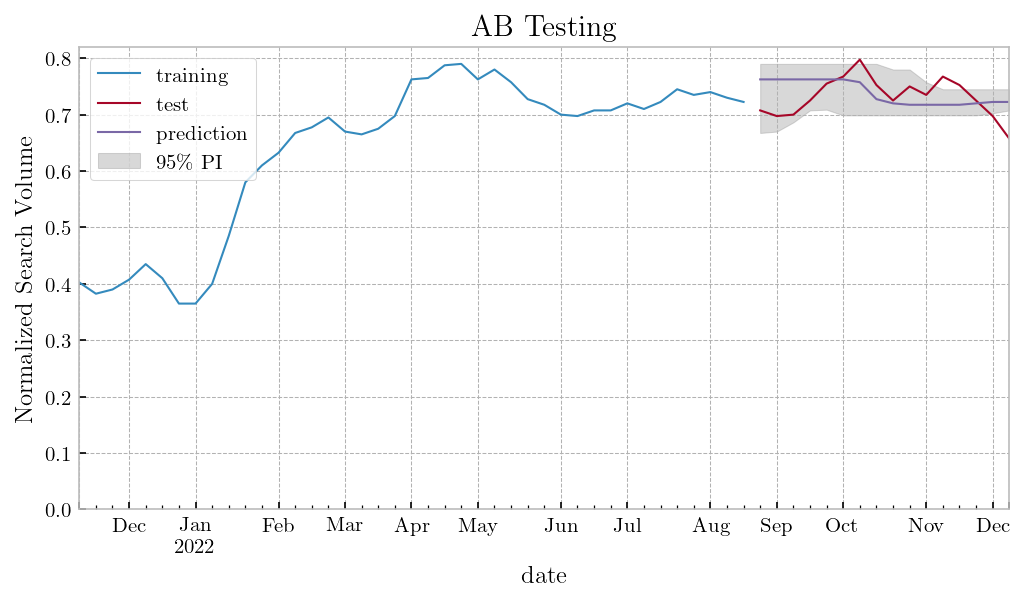

In [22]:
plotPrediction(df_pred_locallgbm, df_ub_locallgbm, df_lb_locallgbm, k=0)

In [23]:
printResults(df_pred_locallgbm, df_test, df_ub_locallgbm, df_lb_locallgbm, namestring="Local LightGBM")

The MAE value for the Local LightGBM is : 0.06642600088967972
The MAPE value for the Local LightGBM is : 1.42685116141813
The average confidence Local LightGBM for the baseline is: 0.08178617482206406


### Local LSTM
We perform the equivalent procedure of local model training but for the LSTM model. 

In [24]:
quantiles = [0.025, 0.5, 0.975] # 95% prediction interval for quantile regression

# plot the model. This plot may not be used.
model_lstm = Sequential([
    Input(shape=(n_in,1), name='Input_layer'),
    LSTM(24, return_sequences=True, name='LSTM_layer_1'),
    LSTM(12, return_sequences=True, name='LSTM_layer_2'),
    LSTM(n_test*len(quantiles), return_sequences=False, activation="tanh", name='LSTM_layer_3'),
    Dense(n_test*len(quantiles), name='Dense_layer'),
    Reshape((n_test, len(quantiles)), name='Reshape_layer')
])
plot_model(model_lstm, show_shapes=True,  to_file='../img_smooth/model_lstm.pdf')

In [25]:
# define the pinball loss
# from https://www.tensorflow.org/addons/api_docs/python/tfa/losses/pinball_loss
def pinball_loss(q, y_true, y_pred):
    diff = y_true - y_pred
    q = tf.constant(q)
    q = tf.reshape(q, (1,1,len(q)))
    return tf.reduce_mean(tf.maximum(q*diff, (q-1.0)*diff))


def train_local_lstm(data_x, data_y, j):
    """
    This function instantiates and lstm model
    """
    tf.random.set_seed(42)
    # Instantiate LSTM model
    model_lstm = Sequential([
        Input(shape=(n_in,1)),
        LSTM(24, return_sequences=True),
        LSTM(12, return_sequences=True),
        LSTM(n_test*len(quantiles), return_sequences=False, activation="tanh"),
        Dense(n_test*len(quantiles)),
        Reshape((n_test, len(quantiles)))
    ])
    

    # Instantiate an early stopping callback to stop training when necessary
    stop_callback = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)#

    # Train Model
    model_lstm.compile(loss=lambda y_true, y_pred: pinball_loss(quantiles, y_true, y_pred), 
                       optimizer="adam", metrics=["mae"])
    model_lstm.fit(data_x, data_y[..., tf.newaxis], 
                  epochs=1000, validation_split=0.1, batch_size=13, shuffle=True, callbacks=[stop_callback],
                  verbose=0)
    
    

    pred_lstm =  model_lstm(df_train.values[-n_in:,[j]].T)

    # get median prediction and prediction intervals
    lb_lstm, pred_lstm, ub_lstm = np.split(pred_lstm, len(quantiles), -1)
    lb_lstm, pred_lstm, ub_lstm = np.squeeze(lb_lstm), np.squeeze(pred_lstm), np.squeeze(ub_lstm)

    # convert the scale
    lb_lstm, pred_lstm, ub_lstm = scipy.special.expit(lb_lstm), scipy.special.expit(pred_lstm), scipy.special.expit(ub_lstm)

    # clip to bounds
    pred_lstm, ub_lstm, lb_lstm = clipOutputs(pred_lstm, ub_lstm, lb_lstm)

    return pred_lstm, ub_lstm, lb_lstm


100%|██████████| 281/281 [18:47<00:00,  4.01s/it]


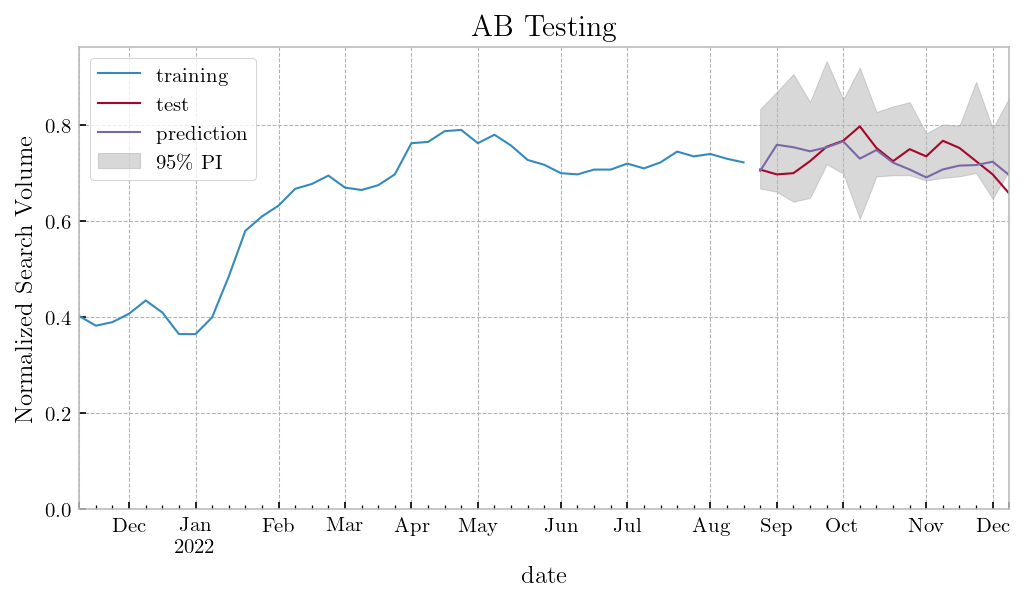

In [26]:
local_lstm = Parallel(n_jobs=1)(delayed(train_local_lstm)(X_train_rf[i], y_train_rf[i], i) for i in tqdm(range(len(X_train_rf))))
pred_locallstm, ub_locallstm, lb_locallstm  = zip(*local_lstm) 
pred_locallstm = np.squeeze(np.stack(pred_locallstm, axis=1))
ub_locallstm = np.squeeze(np.stack(ub_locallstm, axis=1))
lb_locallstm = np.squeeze(np.stack(lb_locallstm, axis=1))

df_pred_locallstm = pd.DataFrame(pred_locallstm, index=df_test.index, columns=df_test.columns)
df_ub_locallstm = pd.DataFrame(ub_locallstm, index=df_test.index, columns=df_test.columns)
df_lb_locallstm = pd.DataFrame(lb_locallstm, index=df_test.index, columns=df_test.columns)

plotPrediction(df_pred_locallstm, df_ub_locallstm, df_lb_locallstm, k=0)

In [27]:
printResults(df_pred_locallstm, df_test, df_ub_locallstm, df_lb_locallstm, namestring="Local LSTM")

The MAE value for the Local LSTM is : 0.0650711265299229
The MAPE value for the Local LSTM is : 1.4154241587788843
The average confidence Local LSTM for the baseline is: 0.12722954154014587


### Local CNN
We perform the equivalent procedure of local model training but for the CNN model. 

In [28]:
# plot the model. This plot may not be used.
model_cnn = Sequential([
    Input(shape=(n_in,1), name='input_layer'),
    Convolution1D(48, kernel_size=3, activation="relu", dilation_rate=1, padding="same", name='conv1D_layer_1'),
    Convolution1D(24, kernel_size=3, activation="relu", padding="same", name='conv1D_layer_2'),
    Convolution1D(3, kernel_size=3, activation="relu", padding="same", name='conv1D_layer_3'),
    Reshape((-1,), name='reshape_layer_1'),
    Dense(3*n_test, name='dense_layer'),
    Reshape((n_test,3), name='reshape_layer_2')
])
plot_model(model_cnn, show_shapes=True, to_file='../img_smooth/model_cnn.pdf')

In [29]:
def train_local_cnn(data_x, data_y, j):
    """
    This function instantiates and CNN model
    """
    tf.random.set_seed(42)
    # Instantiate CNN model
    model_cnn = Sequential([
        Input(shape=(n_in,1)),
        Convolution1D(48, kernel_size=3, activation="relu", dilation_rate=1, padding="same"),
        Convolution1D(24, kernel_size=3, activation="relu", padding="same"),
        Convolution1D(3, kernel_size=3, activation="relu", padding="same"),
    #    Convolution1D(3, kernel_size=1, activation="relu"),
        Reshape((-1,)),
        Dense(3*n_test),
        Reshape((n_test,3))
    ])

    

    # Instantiate an early stopping callback to stop training when necessary
    stop_callback = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)#

    # Train Model
    model_cnn.compile(loss=lambda y_true, y_pred: pinball_loss(quantiles, y_true, y_pred), 
                       optimizer="adam", metrics=["mae"])
    model_cnn.fit(data_x, data_y[..., tf.newaxis], 
                  epochs=1000, validation_split=0.1, batch_size=13, shuffle=True, callbacks=[stop_callback],
                  verbose=0)
    
    

    pred_cnn =  model_cnn(df_train.values[-n_in:,[j]].T)

    # get median prediction and prediction intervals
    lb_cnn, pred_cnn, ub_cnn = np.split(pred_cnn, len(quantiles), -1)
    lb_cnn, pred_cnn, ub_cnn = np.squeeze(lb_cnn), np.squeeze(pred_cnn), np.squeeze(ub_cnn)

    # convert the scale
    lb_cnn, pred_cnn, ub_cnn = scipy.special.expit(lb_cnn), scipy.special.expit(pred_cnn), scipy.special.expit(ub_cnn)

    # clip to bounds
    pred_cnn, ub_cnn, lb_cnn = clipOutputs(pred_cnn, ub_cnn, lb_cnn)

    return pred_cnn, ub_cnn, lb_cnn

  0%|          | 0/281 [00:00<?, ?it/s]

100%|██████████| 281/281 [08:42<00:00,  1.86s/it]


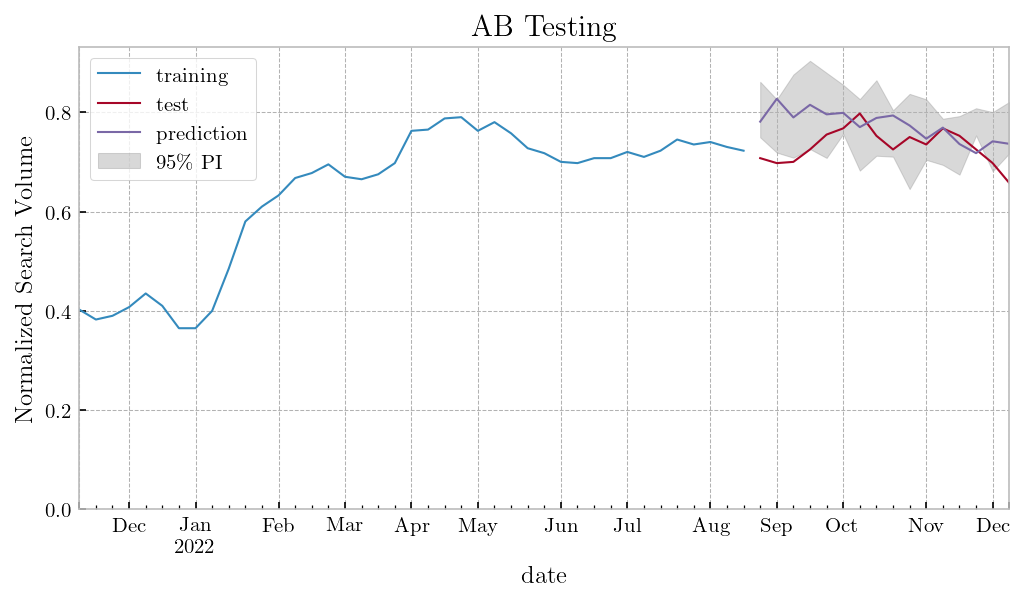

In [30]:
local_cnn = Parallel(n_jobs=1)(delayed(train_local_cnn)(X_train_rf[i], y_train_rf[i], i) for i in tqdm(range(len(X_train_rf))))
pred_localcnn, ub_localcnn, lb_localcnn  = zip(*local_cnn) 
pred_localcnn = np.squeeze(np.stack(pred_localcnn, axis=1))
ub_localcnn = np.squeeze(np.stack(ub_localcnn, axis=1))
lb_localcnn = np.squeeze(np.stack(lb_localcnn, axis=1))

df_pred_localcnn = pd.DataFrame(pred_localcnn, index=df_test.index, columns=df_test.columns)
df_ub_localcnn = pd.DataFrame(ub_localcnn, index=df_test.index, columns=df_test.columns)
df_lb_localcnn = pd.DataFrame(lb_localcnn, index=df_test.index, columns=df_test.columns)

plotPrediction(df_pred_localcnn, df_ub_localcnn, df_lb_localcnn, k=0)

In [31]:
printResults(df_pred_localcnn, df_test, df_ub_localcnn, df_lb_localcnn, namestring="Local CNN")

The MAE value for the Local CNN is : 0.08088375705375142
The MAPE value for the Local CNN is : 1.9751246464644012
The average confidence Local CNN for the baseline is: 0.09914317727088928


## ML/DL Global Modeling
The ML/DL local modeling section covers a group of models which have been trained on all time series simultaneously.

### Global LightGBM 
Random Forest is too slow to train on a large data set. And the same applies to XGBoost. We will therefore use lightGBM. Unfortunately, we cannot work on the differenced time series, because that would make the reconstruction of the confidence intervals impossible.

In [32]:
X_train_rf, y_train_rf = chunkDataset(df_train, n_in=n_in, n_out=n_test)

In [33]:
# instatiate the grid to search the parameters in
gridParams = {
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 400],
    'num_leaves': [20, 30, 40],
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],
    'random_state' : [42], 
    'reg_alpha' : [1,1.5],
    'reg_lambda' : [1,1.5],
    'force_row_wise': [True],
    'metric' : ["l1"],
    'verbose': [-100],
    }

# instantiate a model
lgbm = lgb.LGBMRegressor()

# use 3-fold cross-validation for the parameters
grid = GridSearchCV(lgbm, gridParams,  cv=3, n_jobs=-1)
    

# fit the grid search
grid.fit(X_train_rf, y_train_rf[:,0], eval_metric='l1')

GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'], 'force_row_wise': [True],
                         'learning_rate': [0.001, 0.01, 0.1], 'metric': ['l1'],
                         'n_estimators': [100, 200, 400],
                         'num_leaves': [20, 30, 40],
                         'objective': ['regression'], 'random_state': [42],
                         'reg_alpha': [1, 1.5], 'reg_lambda': [1, 1.5],
                         'verbose': [-100]})

In [34]:
# create a list of datasets
lgb_train = [lgb.Dataset(X_train_rf[:,:], y_train_rf[:,i]) for i in range(n_test)] 

def paramsLightGBM(alpha=None):
    params = grid.best_params_
    params["objective"] = "quantile"
    params["alpha"] = alpha
    return params

# Train the n_test models
models_lgbm = [lgb.train(paramsLightGBM(0.5), lgb_train[i], num_boost_round=20) for i in range(n_test)]
gbm_ub = [lgb.train(paramsLightGBM(0.95), lgb_train[i], num_boost_round=20) for i in range(n_test)]
gbm_lb = [lgb.train(paramsLightGBM(0.05), lgb_train[i], num_boost_round=20) for i in range(n_test)]


# Predict
pred_lgbm = scipy.special.expit(np.array([models_lgbm[i].predict(df_train.values[-n_in:,:].T) for i in range(n_test)]))
ub_lgbm = scipy.special.expit(np.array([gbm_ub[i].predict(df_train.values[-n_in:,:].T) for i in range(n_test)]))
lb_lgbm = scipy.special.expit(np.array([gbm_lb[i].predict(df_train.values[-n_in:,:].T) for i in range(n_test)]))

# Clip in correct range
pred_lgbm, ub_lgbm, lb_lgbm = clipOutputs(pred_lgbm, ub_lgbm, lb_lgbm)

# Cast to Pandas Data Frames
df_pred_lgbm, df_ub_lgbm, df_lb_lgbm = df_test.copy(), df_test.copy(), df_test.copy()

# transfer the output to Pandas Data Frames
df_pred_lgbm[df.columns] = np.array(pred_lgbm)
df_ub_lgbm[df.columns] = np.array(ub_lgbm)
df_lb_lgbm[df.columns] = np.array(lb_lgbm)

/Users/fortunatonucera/miniconda3/envs/THESIS_env2/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


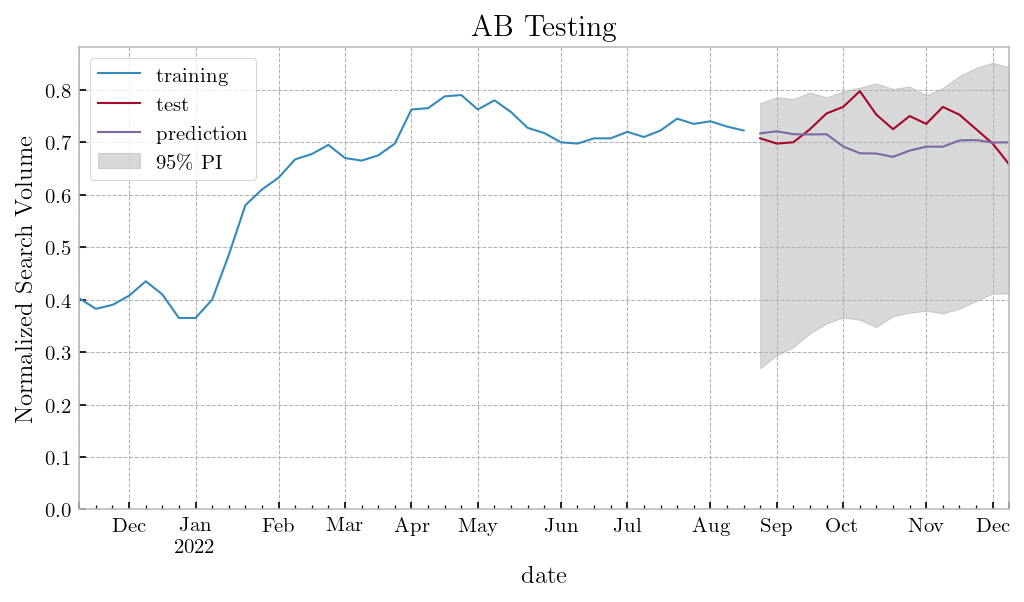

In [35]:
plotPrediction(df_pred_lgbm, df_ub_lgbm, df_lb_lgbm, k=0)

In [36]:
printResults(df_pred_lgbm, df_test, df_ub_lgbm, df_lb_lgbm, namestring="LightGBM")

The MAE value for the LightGBM is : 0.07528215836298932
The MAPE value for the LightGBM is : 1.4549303580091897
The average confidence LightGBM for the baseline is: 0.34415762566725977


### Global LSTM
We will now train an LSTM on the data.

In [37]:
# Instantiate LSTM model
model_lstm = Sequential([
    Input(shape=(n_in,1)),
    LSTM(24, return_sequences=True),
    LSTM(12, return_sequences=True),
    LSTM(n_test*len(quantiles), return_sequences=False, activation="tanh"),
    Dense(n_test*len(quantiles)),
    Reshape((n_test, len(quantiles)))
])

# Instantiate an early stopping callback to stop training when necessary
stop_callback = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)#

# Train Model
model_lstm.compile(loss=lambda y_true, y_pred: pinball_loss(quantiles, y_true, y_pred), 
                   optimizer="adam", metrics=["mae"])
model_lstm.fit(X_train_rf, y_train_rf[..., tf.newaxis], 
              epochs=1000, validation_split=0.1, batch_size=128, shuffle=True, callbacks=[stop_callback], verbose=0)

In [38]:
# obtain the predictions from the network
pred_lstm =  model_lstm.predict(df_train.values[-n_in:,:].T)

# get median prediction and prediction intervals
lb_lstm, pred_lstm, ub_lstm = np.split(pred_lstm, len(quantiles), -1)
lb_lstm, pred_lstm, ub_lstm = np.squeeze(lb_lstm), np.squeeze(pred_lstm), np.squeeze(ub_lstm)

# convert the scale
lb_lstm, pred_lstm, ub_lstm = scipy.special.expit(lb_lstm), scipy.special.expit(pred_lstm), scipy.special.expit(ub_lstm)

# clip to bounds
pred_lstm, ub_lstm, lb_lstm = clipOutputs(pred_lstm, ub_lstm, lb_lstm)

# Cast to Pandas Data Frames
df_pred_lstm, df_ub_lstm, df_lb_lstm = df_test.copy(), df_test.copy(), df_test.copy()

# Transfer the output to Pandas Data Frames
df_pred_lstm[df.columns] = np.array(pred_lstm.T)
df_ub_lstm[df.columns] = np.array(ub_lstm.T)
df_lb_lstm[df.columns] = np.array(lb_lstm.T)

9/9 [==============================] - 0s 2ms/step


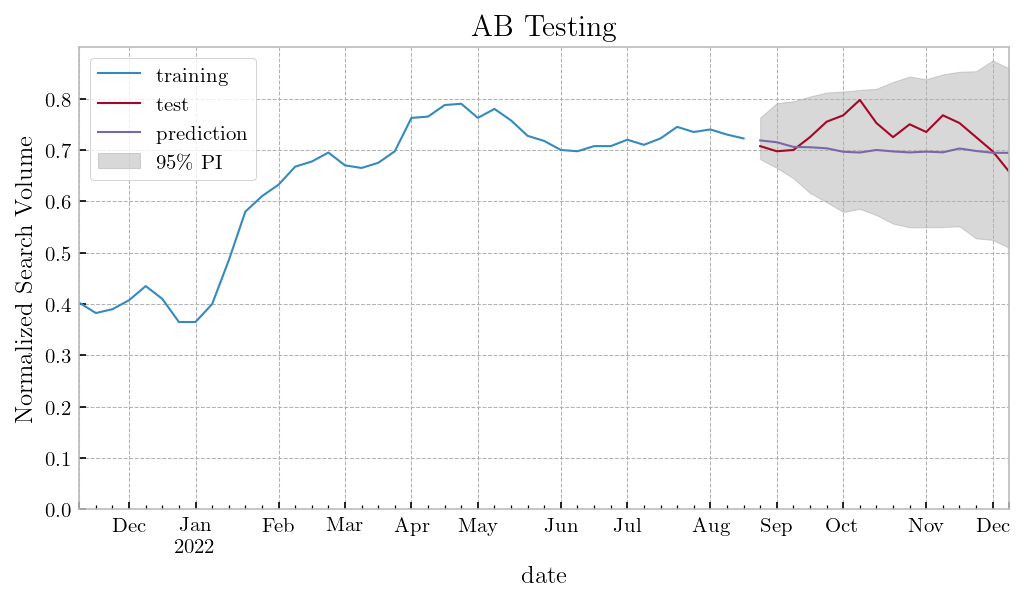

In [39]:
plotPrediction(df_pred_lstm, df_ub_lstm, df_lb_lstm, k=0)

In [40]:
printResults(df_pred_lstm, df_test, df_ub_lstm, df_lb_lstm, namestring="LSTM")

The MAE value for the LSTM is : 0.07203230598112005
The MAPE value for the LSTM is : 0.7381717729952172
The average confidence LSTM for the baseline is: 0.23005768656730652


### Global CNN

In [41]:
model_cnn = Sequential([
        Input(shape=(n_in,1)),
        Convolution1D(48, kernel_size=3, activation="relu", dilation_rate=1, padding="same"),
        Convolution1D(24, kernel_size=3, activation="relu", padding="same"),
        Convolution1D(3, kernel_size=3, activation="relu", padding="same"),
    #    Convolution1D(3, kernel_size=1, activation="relu"),
        Reshape((-1,)),
        Dense(3*n_test),
        Reshape((n_test,3))
])

# Instantiate an early stopping callback to stop training when necessary
stop_callback = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)#

# Train Model
model_cnn.compile(loss=lambda y_true, y_pred: pinball_loss(quantiles, y_true, y_pred), 
                   optimizer="adam", metrics=["mae"])

model_cnn.fit(X_train_rf, y_train_rf[..., tf.newaxis], 
              epochs=1000, validation_split=0.1, batch_size=128, shuffle=True, callbacks=[stop_callback], verbose=0)

In [42]:
# obtain the predictions from the network
pred_cnn =  model_cnn.predict(df_train.values[-n_in:,:].T)

# get median prediction and prediction intervals
lb_cnn, pred_cnn, ub_cnn = np.split(pred_cnn, len(quantiles), -1)
lb_cnn, pred_cnn, ub_cnn = np.squeeze(lb_cnn), np.squeeze(pred_cnn), np.squeeze(ub_cnn)

lb_cnn, pred_cnn, ub_cnn = scipy.special.expit(lb_cnn), scipy.special.expit(pred_cnn), scipy.special.expit(ub_cnn)

# clip to bounds
pred_cnn, ub_cnn, lb_cnn = clipOutputs(pred_cnn, ub_cnn, lb_cnn)

# Cast to Pandas Data Frames
df_pred_cnn, df_ub_cnn, df_lb_cnn = df_test.copy(), df_test.copy(), df_test.copy()

# Transfer the output to Pandas Data Frames
df_pred_cnn[df.columns] = np.array(pred_cnn.T)
df_ub_cnn[df.columns] = np.array(ub_cnn.T)
df_lb_cnn[df.columns] = np.array(lb_cnn.T)

9/9 [==============================] - 0s 597us/step


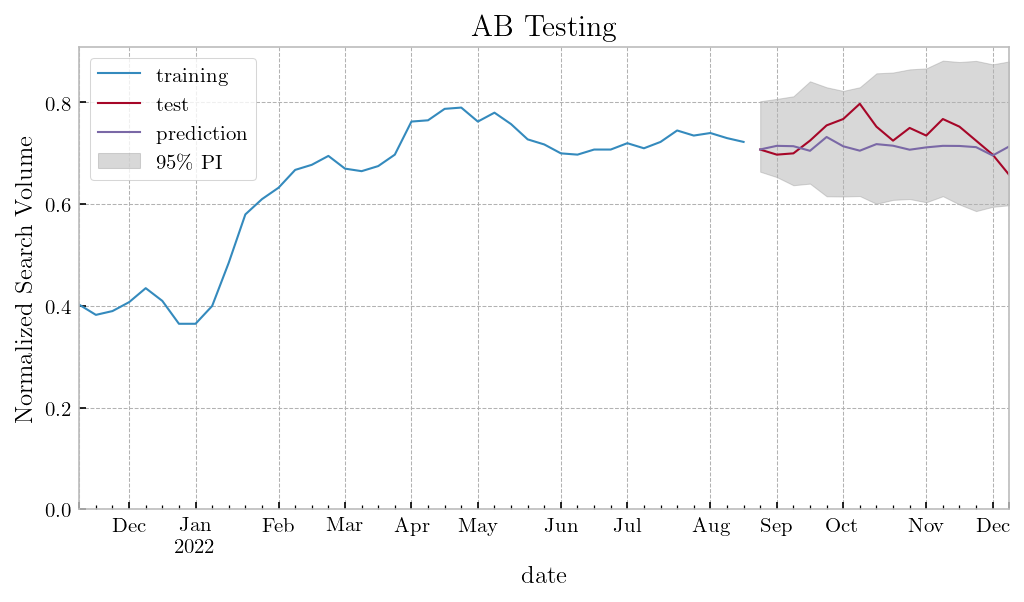

In [43]:
plotPrediction(df_pred_cnn, df_ub_cnn, df_lb_cnn, k=0)

In [44]:
printResults(df_pred_cnn, df_test, df_ub_cnn, df_lb_cnn, namestring="CNN")

The MAE value for the CNN is : 0.06098855798989436
The MAPE value for the CNN is : 0.6617176213508804
The average confidence CNN for the baseline is: 0.18996562063694


## Gaussian Process-based Models

Prepare the data appropriately for training.

In [45]:
# scale the variable
scaler = StandardScaler()

# scale the training set
df_train_scaled = scaler.fit_transform(df_train)

# define the time vector
X = np.arange(df_train.shape[0], dtype=float)[:,None]
X_mean, X_std = X.mean(), X.std()
X = (X - X_mean)/X.std()

# reset seeds
set_seeds()

Prepare the helper functions to be used for training.

In [46]:
def neg_log_likelihood(vector, model, npy=True):
        """
        Calculates the negative log-likelihood of the Gaussian Process
        Inputs:
        - The parameter vector for the model
        - The GP model
        Outputs:
        - The model's negative log-likelihood calculated at vector
        """
        model = copy(model)
        vector = copy(vector)
        try:
            for i in range(len(model.parameters)):
                if model.parameters[i].numpy().shape == (1,):
                    model.parameters[i].assign([tf.constant(vector[i])])
                else:
                    model.parameters[i].assign(tf.constant(vector[i]))
            return -model.log_marginal_likelihood().numpy() if npy else -model.log_marginal_likelihood()

        # special fix to handle cases where the log-likelihood is not well defined
        except:
            return float("inf") #1e-6

def get_mle_params(model):
    """
    Helper function to extract the mle params from the model
    """
    model = copy(model)
    mle_params = np.concatenate([param.numpy().flatten() for param in model.parameters], axis=0)
    return mle_params

# Function which calculates BIC given the model
def BIC(model):
    """
    Helper Function which calculates BIC given the model
    """
    if np.any(np.isnan(model.predict_y(X)[0].numpy())):
        return float("inf")
    model = copy(model)
    out = len(model.parameters)*np.log(model.data[0].shape[0])-2*model.log_marginal_likelihood()
    return tf.constant(out).numpy()


def WBIC(model, n_samples = 100):
    """
    Calculates WBIC via a monte carlo estimate using n_samples samples.
    """
    tf.random.set_seed(42)
    
    model = copy(model)
    mle_params_model = get_mle_params(model)
    
    # get the amount of parameters
    param_n = mle_params_model.shape[0]
    
    # create a distribution to sample from
    joint_distribution = tfp.distributions.Independent(tfp.distributions.Gamma([1.0]*param_n, [1.0]*param_n),reinterpreted_batch_ndims=1)
    
    # sample from the joint distribution
    samples = joint_distribution.sample(n_samples).numpy()
    
    # now loop over the samples and get the likelihood
    beta = 1.0/np.log(model.data[0].shape[0])
    nmle_ests = np.zeros((n_samples,), dtype=np.float64)
    
    for i in range(n_samples):
        nmle_ests[i] = neg_log_likelihood(samples[i], model=model)
    
    # now calculate the numerator and denominator
    numerator = logsumexp(-beta*nmle_ests+np.log(nmle_ests))
    denominator = logsumexp(-beta*nmle_ests)
    
    # calculate output
    out = np.exp(numerator-denominator)
    
    if np.isnan(out):
        out = float("inf")
    
    return out    

Define the routines to load and save the models

In [47]:
# define a decorator to ignore the warnings
def ignore_warnings(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            return func(*args, **kwargs)
    return wrapper

@ignore_warnings
def fitGP_automatic_selection(X,Y, metric_func=BIC, nreps=5):
    """
    Finds the best Gaussian Process Model given inputs and outputs
    Inputs:
    - X : input data, must be 2D
    - Y : output data, must be 2D
    - metric_func : the metric function used for the selection criterion
    - nreps : the number of times the initialization is performed
    Returns:
    - the final model
    """

    # check that X and Y are 2D
    assert len(X.shape) == 2
    assert len(Y.shape) == 2
    
    def limit_param(low,high):
        """
        helper function that limits the values the parameters can take
        """
        out = gpflow.Parameter(tf.cast(1.0, tf.float64), 
                 transform=tfb.Sigmoid(low=tf.cast(low,tf.float64), 
                                       high=tf.cast(high, tf.float64)))
        return out
        
    
    # Define base kernels
    kernels = [
        gpflow.kernels.White(variance = limit_param(1e-7, 1e7)),
        gpflow.kernels.Constant(variance = limit_param(1e-7, 1e7)),
        gpflow.kernels.Linear(variance = limit_param(1e-7, 1e7)),
        gpflow.kernels.SquaredExponential(variance = limit_param(1e-7, 1e7),
                                         lengthscales=limit_param(1e-7, 1e7)),
        gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(variance = limit_param(1e-7, 1e7),
                                         lengthscales=limit_param(1e-7, 1e7)),
                                period = limit_param(1e-7, 1e7))
        ]
    
    # Assign the priors
    for kernel in kernels:
        for param in kernel.parameters:
            param.prior = tfp.distributions.Gamma(gpflow.utilities.to_default_float(1.0), gpflow.utilities.to_default_float(1.0))

    # Define a model wrapper for ease of use
    model_wrapper = lambda kernel: gpflow.models.GPR(data=(X, Y), kernel=kernel, mean_function=None)
        
    # Define an optimizer
    optimizer = Scipy()  

    # Instantiate BIC
    current_BIC = float("inf")
    best_model = model_wrapper(kernels[0])

    # Operate a first loop
    for k_try in kernels:
        k_try = copy(k_try)
        
        model_nreps      = []
        model_nreps_loss = []
        for i in range(nreps):
            model = model_wrapper(k_try)

            # randomize the parameters
            for parameter in model.trainable_parameters:
                # Check if the parameter is scalar or vector
                shape = parameter.shape
                if len(shape) == 0:  # scalar parameter
                    parameter.assign(np.random.gamma(1.0,1.0))
                elif shape==(1,):  # vector parameter
                    parameter.assign([np.random.gamma(1.0,1.0)])
        
            optimizer.minimize(model.training_loss, model.trainable_variables,
                               options=dict(maxiter=5000), method="Nelder-Mead")
            
            model_nreps.append(copy(model))
            model_nreps_loss.append(model.training_loss())
        
        model = copy(model_nreps[np.argmin(model_nreps_loss)])
        del model_nreps, model_nreps_loss
            
            
        # calculate the metric
        trial_BIC = metric_func(model)
        if trial_BIC < current_BIC:
            best_model = model
            current_BIC = trial_BIC
    

    # Set the initial "Improved" flag to True.
    improved = True
    depth=0
    
    while (improved is True) and (depth < 15):
        
        depth += 1

        # Set no improvement
        improved = False

        # Set a model collector and a bic collector
        model_collector = []
        bic_collector = []

        # Get Best Model's kernel
        best_kernel = best_model.kernel

        # Other loops over operations
        for operation in ["+", "*"]:

            # Loop over new kernels to find a new best model
            for k_try in kernels:
                if  operation == "+":
                    k_try = copy(k_try)+copy(best_kernel)
                elif operation == "*":
                    k_try = copy(k_try)*copy(best_kernel)

                model_nreps      = []
                model_nreps_loss = []
                for i in range(nreps):
                    model = model_wrapper(k_try)

                    # randomize the parameters
                    for parameter in model.trainable_parameters:
                        # Check if the parameter is scalar or vector
                        shape = parameter.shape
                        if len(shape) == 0:  # scalar parameter
                            parameter.assign(np.random.gamma(1.0,1.0))
                        elif shape==(1,):  # vector parameter
                            parameter.assign([np.random.gamma(1.0,1.0)])

                    optimizer.minimize(model.training_loss, model.trainable_variables,
                                       options=dict(maxiter=5000), method="Nelder-Mead")

                    model_nreps.append(copy(model))
                    model_nreps_loss.append(model.training_loss())

                model = copy(model_nreps[np.argmin(model_nreps_loss)])
                del model_nreps, model_nreps_loss
                
                # calculate the metric
                trial_BIC = metric_func(model)

                # save model and bic
                model_collector.append(model)
                bic_collector.append(trial_BIC)

        # Loop over changepoint 
        for operation in ["same", "c_before", "c_after"]:
            # Choose whether to place a changepoint with constant kernel before, after, or same kernel.
            if operation == "same":
                k_try = gpflow.kernels.ChangePoints([copy(best_kernel),copy(best_kernel)], [X.mean()])
            elif operation == "c_before":
                k_try = gpflow.kernels.ChangePoints([gpflow.kernels.Constant(1),copy(best_kernel)], [X.mean()])
            elif operation == "c_after":
                k_try = gpflow.kernels.ChangePoints([copy(best_kernel), gpflow.kernels.Constant(1)], [X.mean()])

            model_nreps      = []
            model_nreps_loss = []
            for i in range(nreps):
                model = model_wrapper(k_try)

                # randomize the parameters
                for parameter in model.trainable_parameters:
                    # Check if the parameter is scalar or vector
                    shape = parameter.shape
                    if len(shape) == 0:  # scalar parameter
                        parameter.assign(np.random.gamma(1.0,1.0))
                    elif shape==(1,):  # vector parameter
                        parameter.assign([np.random.gamma(1.0,1.0)])

                optimizer.minimize(model.training_loss, model.trainable_variables,
                                   options=dict(maxiter=5000), method="Nelder-Mead")

                model_nreps.append(copy(model))
                model_nreps_loss.append(model.training_loss())

            model = copy(model_nreps[np.argmin(model_nreps_loss)])
            del model_nreps, model_nreps_loss
            
            # calculate the metric
            trial_BIC = metric_func(model)

            # save model and bic
            model_collector.append(model)
            bic_collector.append(trial_BIC)

        # Find the best bic at the given iteration
        best_bic_at_iteration = np.min(bic_collector)

        # If BIC has improved, continue. Else, the while loop breaks, and we move on.
        if best_bic_at_iteration < current_BIC:
            current_BIC = best_bic_at_iteration
            best_model = model_collector[np.argmin(bic_collector)]
            improved = True
        
        # 
        
    return best_model

Create a function to save the GP models

In [48]:
def saveGPModel(model, pathToSave, func=BIC):
    """
    This function is a helper to save the gpflow model to disk
    """
    
    # instantiate the functions
    model.predict_f_compiled = tf.function(
        model.predict_f, input_signature=[tf.TensorSpec(shape=[None, 1], dtype=tf.float64)]
    )
    model.predict_y_compiled = tf.function(
        model.predict_y, input_signature=[tf.TensorSpec(shape=[None, 1], dtype=tf.float64)]
    )
    model.predict_f_samples_compiled = tf.function(
        model.predict_f_samples, input_signature=[tf.TensorSpec(shape=[None, 1], dtype=tf.float64),
                                                  tf.TensorSpec(shape=(), dtype=tf.int64)]
    )
    model.predict_f_samples_compiled = tf.function(
        model.predict_f_samples, input_signature=[tf.TensorSpec(shape=[None, 1], dtype=tf.float64),
                                                  tf.TensorSpec(shape=(), dtype=tf.int64)]
    )
    
    # save model
    tf.saved_model.save(model, pathToSave)
    
def loadGPModel(pathToLoad):
    """
    This function is a helper to load a gpflow model from disk
    """
    return tf.saved_model.load(pathToLoad)

Train the model with WBIC (or load if available)

In [49]:
# if the models are saved on disk, load. Otherwise, we calculate them 
folder = os.path.join(model_output_folder, "wbic_models")
if os.path.isdir(folder):
    best_model_WBIC = [loadGPModel(os.path.join(folder, column)) for column in tqdm(list(df_train.columns))]
else:
    # calculate
    os.makedirs(folder)
    best_model_WBIC=Parallel(30)(delayed(fitGP_automatic_selection)(X, df_train_scaled[:,i][:,None], WBIC) for i in tqdm(range(df_train.shape[1])))
    _ = [saveGPModel(model, os.path.join(folder, df_train.columns[i]), WBIC) for i, model in enumerate(best_model_WBIC)]   


100%|██████████| 281/281 [01:33<00:00,  3.00it/s]


Train the model with BIC (or load if available)

In [50]:
# if the models are saved on disk, load. Otherwise, we calculate them 
folder = os.path.join(model_output_folder, "bic_models")
if os.path.isdir(folder):
    best_model_BIC = [loadGPModel(os.path.join(folder, column)) for column in tqdm(list(df_train.columns))]
else:
    # calculate
    os.makedirs(folder)
    best_model_BIC=Parallel(30)(delayed(fitGP_automatic_selection)(X, df_train_scaled[:,i][:,None], BIC) for i in tqdm(range(df_train.shape[1])))
    _ = [saveGPModel(model, os.path.join(folder, df_train.columns[i]), BIC) for i, model in enumerate(best_model_BIC)]   

100%|██████████| 281/281 [03:33<00:00,  1.32it/s]


Visualize one of the results.

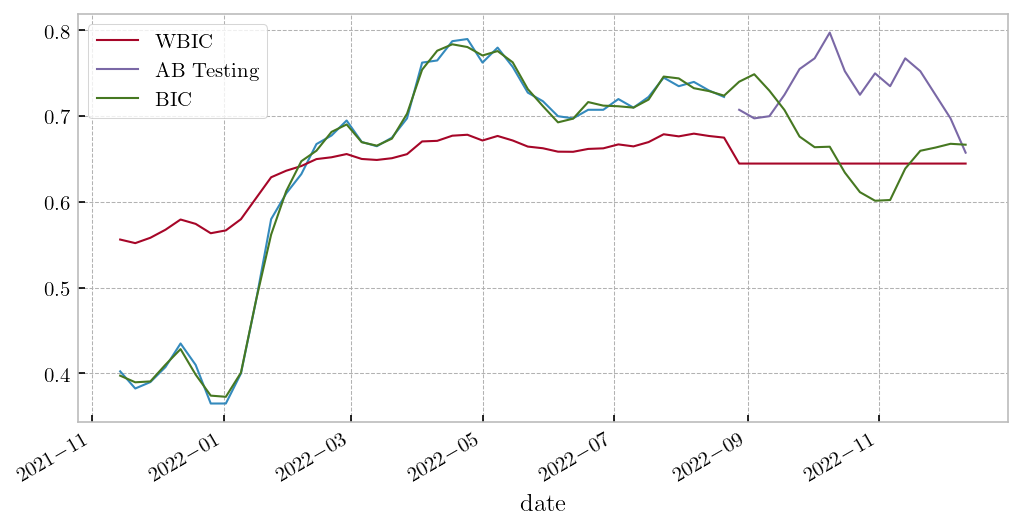

In [51]:
# provide a plot example for the models
k = 0
X = (np.arange(df.shape[0])[:,None]-X_mean)/X_std
plt.plot(expit(df_train.iloc[:,k]))
try:
    pred, var = best_model_WBIC[k].predict_y_compiled(X)
except:
    pred, var = best_model_WBIC[k].predict_y(X)
    
pred, var = pred*scaler.scale_[k]+scaler.mean_[k], var*(scaler.scale_[k])**2.0
pred = expit(pred)
plt.plot(df.index, pred, label="WBIC")
df_test.iloc[:,k].plot()

try:
    pred, var = best_model_BIC[k].predict_y_compiled(X)
except:
    pred, var = best_model_BIC[k].predict_y(X)
    
pred, var = pred*scaler.scale_[k]+scaler.mean_[k], var*(scaler.scale_[k])**2.0
pred = expit(pred)
plt.plot(df.index, pred, label="BIC")

plt.legend()

Then obtain the predictions from both WBIC and BIC based GPs.

In [52]:
# Instantiate the forecast range
X = (np.arange(df.shape[0])[:,None]-X_mean)/X_std

# Obtain predictions from WBIC
preds_WBIC, ub_WBIC, lb_WBIC  = df.copy(), df.copy(), df.copy()
for i, model in enumerate(best_model_WBIC):
    
    # obtain mean and variance of the trained GP
    try:
        pred, var = model.predict_y_compiled(X)
    except:
        pred, var = model.predict_y(X)
    pred, std = np.squeeze(pred), np.sqrt(np.squeeze(var))

    # obtain upper and lower PI
    ub, lb = pred+stats.norm.ppf(0.975)*std, pred-stats.norm.ppf(0.975)*std

    # append this info
    preds_WBIC.iloc[:,i] = pred
    ub_WBIC.iloc[:,i] = ub
    lb_WBIC.iloc[:,i] = lb
    
# obtain predictions from BIC
preds_BIC, ub_BIC, lb_BIC  = df.copy(), df.copy(), df.copy()
for i, model in enumerate(best_model_BIC):
    
    # obtain mean and variance of the trained GP
    try:
        pred, var = model.predict_y_compiled(X)
    except:
        pred, var = model.predict_y(X)
    pred, std = np.squeeze(pred), np.sqrt(np.squeeze(var))

    # obtain upper and lower PI
    ub, lb = pred+stats.norm.ppf(0.975)*std, pred-stats.norm.ppf(0.975)*std

    # append this info
    preds_BIC.iloc[:,i] = pred
    ub_BIC.iloc[:,i] = ub
    lb_BIC.iloc[:,i] = lb


Rescale and transform into `Pandas` DataFrames

In [53]:
preds_BIC, ub_BIC, lb_BIC = (expit(scaler.inverse_transform(dataFrame)) for dataFrame in [preds_BIC, ub_BIC, lb_BIC])
preds_BIC, ub_BIC, lb_BIC = (pd.DataFrame(dataFrame, columns=df.columns, index=df.index).clip(0.0,1.0) for dataFrame in [preds_BIC, ub_BIC, lb_BIC])
preds_BIC, ub_BIC, lb_BIC = clipOutputs(preds_BIC, ub_BIC, lb_BIC)

In [54]:
preds_WBIC, ub_WBIC, lb_WBIC = (expit(scaler.inverse_transform(dataFrame)) for dataFrame in [preds_WBIC, ub_WBIC, lb_WBIC])
preds_WBIC, ub_WBIC, lb_WBIC = (pd.DataFrame(dataFrame, columns=df.columns, index=df.index).clip(0.0,1.0) for dataFrame in [preds_WBIC, ub_WBIC, lb_WBIC])
preds_WBIC, ub_WBIC, lb_WBIC = clipOutputs(preds_WBIC, ub_WBIC, lb_WBIC)

Get the flag for missing values in BIC. This seems to be uniquely a problem with the BIC-based GP routine.

In [55]:
flag = ~preds_BIC.isna().any().values

In [56]:
printResults(preds_BIC.iloc[-n_test:,flag], df_test.iloc[:,flag], ub_BIC.iloc[-n_test:,flag], lb_BIC.iloc[-n_test:,flag], "BIC-based GP")
printResults(preds_WBIC.iloc[-n_test:,flag], df_test.iloc[:,flag], ub_WBIC.iloc[-n_test:,flag], lb_WBIC.iloc[-n_test:,flag], "WBIC-based GP")
printResults(preds_WBIC.iloc[-n_test:,:], df_test, ub_WBIC.iloc[-n_test:,:], lb_WBIC.iloc[-n_test:,:], "WBIC-based GP")

The MAE value for the BIC-based GP is : 0.06381768637992832
The MAPE value for the BIC-based GP is : 1.0681317233606167
The average confidence BIC-based GP for the baseline is: 0.251184917562724
The MAE value for the WBIC-based GP is : 0.04904430510752688
The MAPE value for the WBIC-based GP is : 0.686506409284829
The average confidence WBIC-based GP for the baseline is: 0.29476527710573475
The MAE value for the WBIC-based GP is : 0.04890910342526691
The MAPE value for the WBIC-based GP is : 0.6822237578430207
The average confidence WBIC-based GP for the baseline is: 0.29413465235765124


## Hybrid Models

### Hybrid Models: Residuals + Original Time Series Clustering

In [57]:
quantiles = [0.025, 0.5, 0.975]

set_seeds(42)

preds_LAMBDA = {}
ooc_metric = []
lambda_keys = list(np.linspace(0.5,1.0,10))

for LAMBDA in lambda_keys:
    df_diff = expit(df_train)-LAMBDA*preds_WBIC.loc[df_train.index,:]
    
    # From Milestone 2
    # Generate an empty distance matrix
    distance_matrix = np.zeros((df.shape[1],df.shape[1]), dtype=float)

    # Parallelize the computation across the available cores
    parallel = Parallel(-1)

    df_replace = expit(df_train)

    # Write the wrapper for distance calculation
    def wrapperDTW(i,j):
        """
        wrapper to calculate dtw between time series i and j in the data set
        """
        out = dtw(df_replace.values[:,i], df_replace.values[:,j], window_type="sakoechiba", window_args={"window_size": 2}).distance
        return (i,j,out)

    # Calculate DTW
    output = parallel(delayed(wrapperDTW)(i,j) for i in tqdm(range(df_train_scaled.shape[1])) for j in range(i, df_train_scaled.shape[1]))

    # Collect the data from the data structure which was output from the parallel computation
    for element in output:
        distance_matrix[element[0], element[1]] = element[2]
        distance_matrix[element[1], element[0]] = element[2]

    hdb = HDBSCAN(min_cluster_size=5)
    hdb.fit(distance_matrix)
    hdb.labels_ += 1
    #hdb.labels_[:] = 0
    
    dframes = []
    for i in np.unique(hdb.labels_):
        dframes.append(df_diff.iloc[:,hdb.labels_==i])

    n_in = int(n_test*1.0)
    df_train_chunks = [chunkDataset(dataFrame, n_in=n_in) for dataFrame in dframes]


    ic_metric = []
    cluster_wise_models = []
    for i in tqdm(range(len(df_train_chunks))):
        model_cnn = Sequential([
                Input(shape=(n_in,1)),
                Convolution1D(24, kernel_size=3, activation="relu"),
                Convolution1D(12, kernel_size=3, activation="relu"),
                Convolution1D(6, kernel_size=3, activation="relu"),
                Reshape((-1,)),
                Dense(3*n_test),
                Reshape((n_test,3))
        ])

        # Instantiate an early stopping callback to stop training when necessary
        stop_callback = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)#

        # Train Model
        model_cnn.compile(loss=lambda y_true, y_pred: pinball_loss(quantiles, y_true, y_pred), 
                        optimizer="adam", metrics=["mae"])
        model_cnn.fit(df_train_chunks[i][0], df_train_chunks[i][1][..., tf.newaxis], 
                    epochs=1000, validation_split=0.1, batch_size=df_train_chunks[i][0].shape[0], shuffle=True, callbacks=[stop_callback],
                    verbose=0)
        
        cluster_wise_models.append(model_cnn)
        # check 1-step accuracy
        temp_data = chunkDataset(df_diff.iloc[:,hdb.labels_==i], n_in=n_test, n_out=1)
        ic_metric.append([np.mean(np.abs(np.squeeze(model_cnn(temp_data[0]))[...,1][...,0]-np.squeeze(temp_data[1]))/np.abs(np.squeeze(temp_data[1]))), np.sum(hdb.labels_==i)])



    diff_preds = []
    # now we need to predict on the test set
    for j in range(df_diff.shape[1]):
        # find cluster belonging
        s = hdb.labels_[j] # add 1 to adjust belonging to python list
        # get the last n_in
        inputs = df_diff.iloc[-n_in:,j].values.reshape(1,-1)
        preds = np.squeeze(cluster_wise_models[s](inputs))[...,1]
        diff_preds.append(preds)

    # introduce diff_preds
    preds_LAMBDA[LAMBDA] = np.array(diff_preds).T + LAMBDA*preds_WBIC.iloc[-n_test:,:].values


    ic_metric = np.array(ic_metric)
    ic_metric = np.sum(ic_metric[:,0]*ic_metric[:,1])/np.sum(ic_metric[:,1])
    ooc_metric.append(ic_metric)

# modify the ooc_metric for weighting
ooc_metric = 1.0/np.array(ooc_metric)
ooc_metric /= np.sum(ooc_metric)

preds_hybrid_cluster_orig = np.sum([preds_LAMBDA[key]*ooc_metric[i] for i, key in enumerate(lambda_keys)], axis=0)

100%|██████████| 8/8 [00:12<00:00,  1.62s/it]


### Hybrid Models: Residuals + Residuals Time Series Clustering

In [58]:
set_seeds(42)

preds_LAMBDA = {}
ooc_metric = []
lambda_keys = list(np.linspace(0.5,1.0,10))

for LAMBDA in lambda_keys:
    df_diff = expit(df_train)-LAMBDA*preds_WBIC.loc[df_train.index,:]
    
    # From Milestone 2
    # Generate an empty distance matrix
    distance_matrix = np.zeros((df.shape[1],df.shape[1]), dtype=float)

    # Parallelize the computation across the available cores
    parallel = Parallel(-1)

    df_replace = expit(df_train)
    # Write the wrapper for distance calculation
    def wrapperDTW(i,j):
        """
        wrapper to calculate dtw between time series i and j in the data set
        """
        #out = dtw(df_diff.values[:,i], df_diff.values[:,j], dist_method=lambda x,y: abs(x-y),  window_type="sakoechiba", window_args={"window_size": 2}).distance
        #out = dtw(df_diff.values[:,i], df_diff.values[:,j]).distance
        out = dtw(df_diff.values[:,i], df_diff.values[:,j], window_type="sakoechiba", window_args={"window_size": 2}).distance
        return (i,j,out)

    # Calculate DTW
    output = parallel(delayed(wrapperDTW)(i,j) for i in tqdm(range(df_train_scaled.shape[1])) for j in range(i, df_train_scaled.shape[1]))

    # Collect the data from the data structure which was output from the parallel computation
    for element in output:
        distance_matrix[element[0], element[1]] = element[2]
        distance_matrix[element[1], element[0]] = element[2]

    hdb = HDBSCAN(min_cluster_size=5)
    hdb.fit(distance_matrix)
    hdb.labels_ += 1
    #hdb.labels_[:] = 0
    
    dframes = []
    for i in np.unique(hdb.labels_):
        dframes.append(df_diff.iloc[:,hdb.labels_==i])

    n_in = int(n_test*1.0)
    df_train_chunks = [chunkDataset(dataFrame, n_in=n_in) for dataFrame in dframes]


    ic_metric = []
    cluster_wise_models = []
    for i in tqdm(range(len(df_train_chunks))):
        model_cnn = Sequential([
                Input(shape=(n_in,1)),
                Convolution1D(24, kernel_size=3, activation="relu"),
                Convolution1D(12, kernel_size=3, activation="relu"),
                Convolution1D(6, kernel_size=3, activation="relu"),
                Reshape((-1,)),
                Dense(3*n_test),
                Reshape((n_test,3))
        ])

        # Instantiate an early stopping callback to stop training when necessary
        stop_callback = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)#

        # Train Model
        model_cnn.compile(loss=lambda y_true, y_pred: pinball_loss(quantiles, y_true, y_pred), 
                        optimizer="adam", metrics=["mae"])
        model_cnn.fit(df_train_chunks[i][0], df_train_chunks[i][1][..., tf.newaxis], 
                    epochs=1000, validation_split=0.1, batch_size=df_train_chunks[i][0].shape[0], shuffle=True, callbacks=[stop_callback],
                    verbose=0)
        
        cluster_wise_models.append(model_cnn)
        # check 1-step accuracy
        temp_data = chunkDataset(df_diff.iloc[:,hdb.labels_==i], n_in=n_test, n_out=1)
        ic_metric.append([np.mean(np.abs(np.squeeze(model_cnn(temp_data[0]))[...,1][...,0]-np.squeeze(temp_data[1]))/np.abs(np.squeeze(temp_data[1]))), np.sum(hdb.labels_==i)])



    diff_preds = []
    # now we need to predict on the test set
    for j in range(df_diff.shape[1]):
        # find cluster belonging
        s = hdb.labels_[j] # add 1 to adjust belonging to python list
        # get the last n_in
        inputs = df_diff.iloc[-n_in:,j].values.reshape(1,-1)
        preds = np.squeeze(cluster_wise_models[s](inputs))[...,1]
        diff_preds.append(preds)

    # introduce diff_preds
    preds_LAMBDA[LAMBDA] = np.array(diff_preds).T + LAMBDA*preds_WBIC.iloc[-n_test:,:].values


    ic_metric = np.array(ic_metric)
    ic_metric = np.sum(ic_metric[:,0]*ic_metric[:,1])/np.sum(ic_metric[:,1])
    ooc_metric.append(ic_metric)

# modify the ooc_metric for weighting
ooc_metric = 1.0/np.array(ooc_metric)
ooc_metric /= np.sum(ooc_metric)

preds_hybrid_cluster_diff = np.sum([preds_LAMBDA[key]*ooc_metric[i] for i, key in enumerate(lambda_keys)], axis=0)

100%|██████████| 3/3 [00:04<00:00,  1.35s/it]


### Hybrid Models: Global Model

In [59]:
set_seeds(42)

preds_LAMBDA = {}
ooc_metric = []
lambda_keys = list(np.linspace(0.5,1.0,10))

for LAMBDA in lambda_keys:
    df_diff = expit(df_train)-LAMBDA*preds_WBIC.loc[df_train.index,:]
    
    # From Milestone 2
    # Generate an empty distance matrix
    distance_matrix = np.zeros((df.shape[1],df.shape[1]), dtype=float)

    # Parallelize the computation across the available cores
    parallel = Parallel(-1)

    df_replace = expit(df_train)
    # Write the wrapper for distance calculation
    def wrapperDTW(i,j):
        """
        wrapper to calculate dtw between time series i and j in the data set
        """
        #out = dtw(df_diff.values[:,i], df_diff.values[:,j], dist_method=lambda x,y: abs(x-y),  window_type="sakoechiba", window_args={"window_size": 2}).distance
        #out = dtw(df_diff.values[:,i], df_diff.values[:,j]).distance
        out = dtw(df_diff.values[:,i], df_diff.values[:,j], window_type="sakoechiba", window_args={"window_size": 2}).distance
        return (i,j,out)

    # Calculate DTW
    output = parallel(delayed(wrapperDTW)(i,j) for i in tqdm(range(df_train_scaled.shape[1])) for j in range(i, df_train_scaled.shape[1]))

    # Collect the data from the data structure which was output from the parallel computation
    for element in output:
        distance_matrix[element[0], element[1]] = element[2]
        distance_matrix[element[1], element[0]] = element[2]

    hdb = HDBSCAN(min_cluster_size=5)
    hdb.fit(distance_matrix)
    hdb.labels_ += 1
    hdb.labels_[:] = 0
    
    dframes = []
    for i in np.unique(hdb.labels_):
        dframes.append(df_diff.iloc[:,hdb.labels_==i])

    n_in = int(n_test*1.0)
    df_train_chunks = [chunkDataset(dataFrame, n_in=n_in) for dataFrame in dframes]


    ic_metric = []
    cluster_wise_models = []
    for i in tqdm(range(len(df_train_chunks))):
        model_cnn = Sequential([
                Input(shape=(n_in,1)),
                Convolution1D(24, kernel_size=3, activation="relu"),
                Convolution1D(12, kernel_size=3, activation="relu"),
                Convolution1D(6, kernel_size=3, activation="relu"),
                Reshape((-1,)),
                Dense(3*n_test),
                Reshape((n_test,3))
        ])

        # Instantiate an early stopping callback to stop training when necessary
        stop_callback = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)#

        # Train Model
        model_cnn.compile(loss=lambda y_true, y_pred: pinball_loss(quantiles, y_true, y_pred), 
                        optimizer="adam", metrics=["mae"])
        model_cnn.fit(df_train_chunks[i][0], df_train_chunks[i][1][..., tf.newaxis], 
                    epochs=1000, validation_split=0.1, batch_size=df_train_chunks[i][0].shape[0], shuffle=True, callbacks=[stop_callback],
                    verbose=0)
        
        cluster_wise_models.append(model_cnn)
        # check 1-step accuracy
        temp_data = chunkDataset(df_diff.iloc[:,hdb.labels_==i], n_in=n_test, n_out=1)
        ic_metric.append([np.mean(np.abs(np.squeeze(model_cnn(temp_data[0]))[...,1][...,0]-np.squeeze(temp_data[1]))/np.abs(np.squeeze(temp_data[1]))), np.sum(hdb.labels_==i)])



    diff_preds = []
    # now we need to predict on the test set
    for j in range(df_diff.shape[1]):
        # find cluster belonging
        s = hdb.labels_[j] # add 1 to adjust belonging to python list
        # get the last n_in
        inputs = df_diff.iloc[-n_in:,j].values.reshape(1,-1)
        preds = np.squeeze(cluster_wise_models[s](inputs))[...,1]
        diff_preds.append(preds)

    # introduce diff_preds
    preds_LAMBDA[LAMBDA] = np.array(diff_preds).T + LAMBDA*preds_WBIC.iloc[-n_test:,:].values


    ic_metric = np.array(ic_metric)
    ic_metric = np.sum(ic_metric[:,0]*ic_metric[:,1])/np.sum(ic_metric[:,1])
    ooc_metric.append(ic_metric)

# modify the ooc_metric for weighting
ooc_metric = 1.0/np.array(ooc_metric)
ooc_metric /= np.sum(ooc_metric)

preds_hybrid_nocluster = np.sum([preds_LAMBDA[key]*ooc_metric[i] for i, key in enumerate(lambda_keys)], axis=0)

100%|██████████| 1/1 [00:05<00:00,  5.43s/it]


# Results
This section of the notebook will focus on the errors that each model achieves. These visualizations will be used for the results.

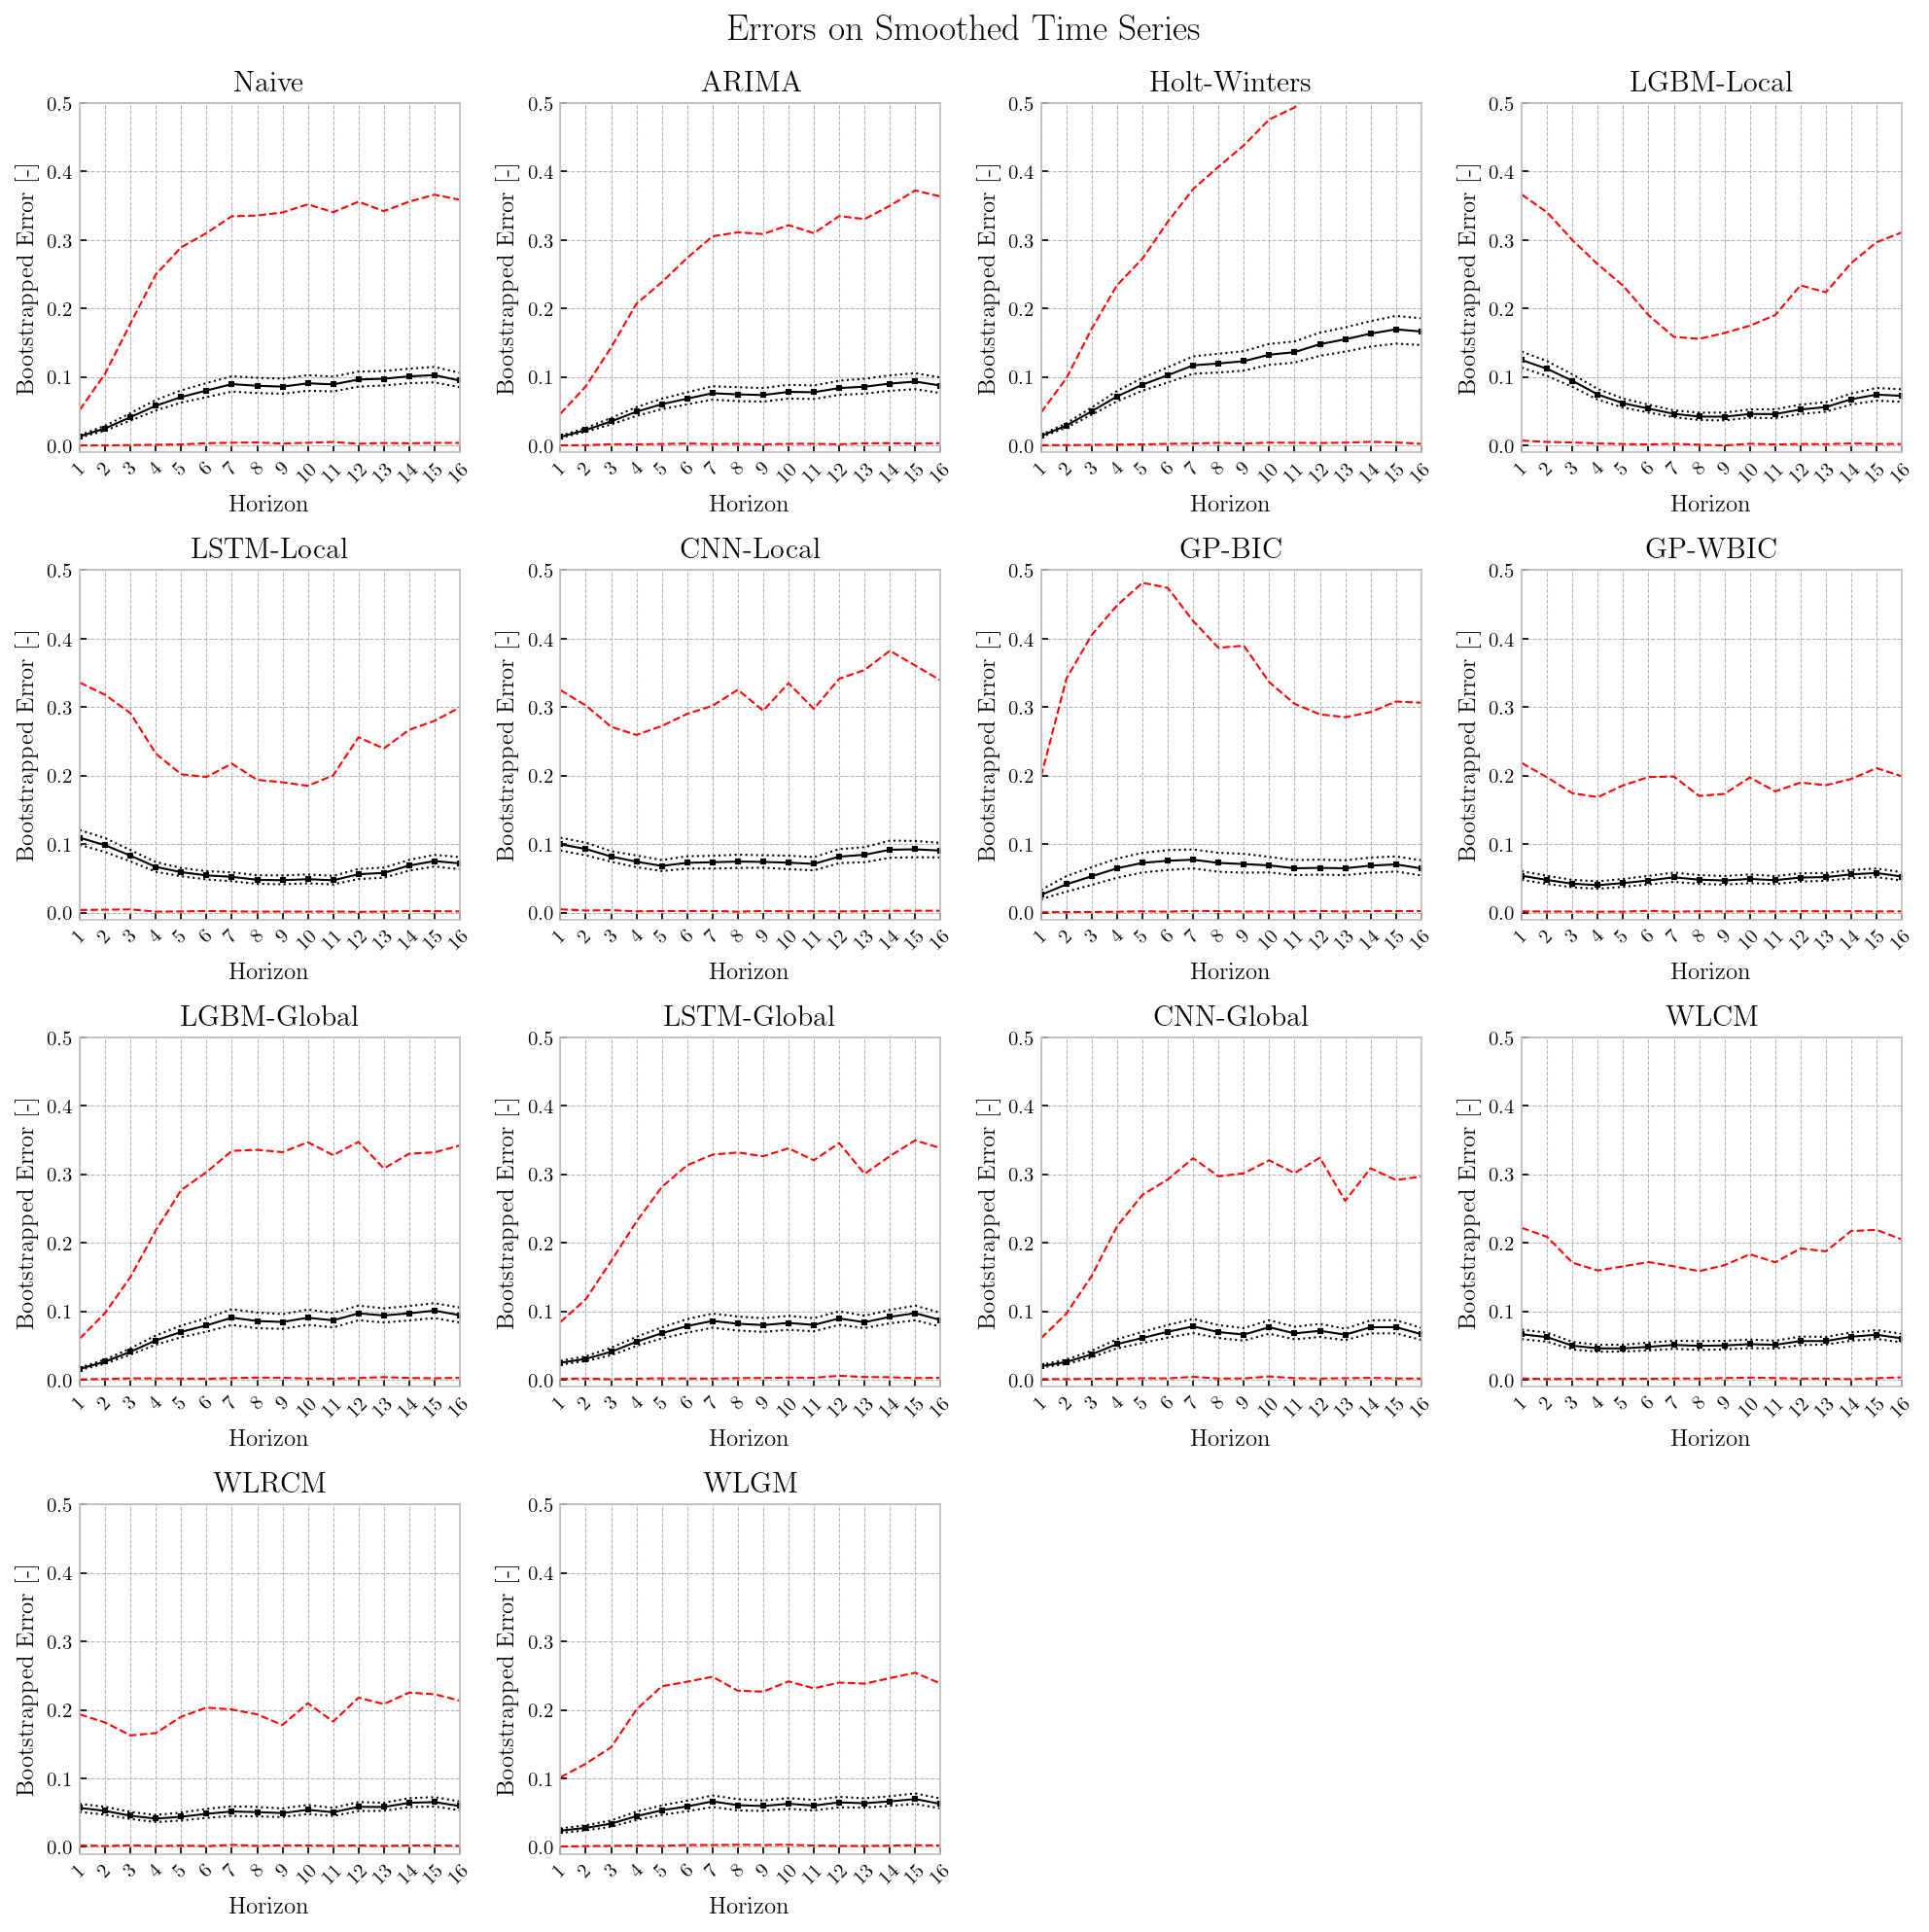

In [60]:
predictions_list = [ 
    # naive
    df_pred_baseline.values,

    # arima
    df_pred_arima.values,
    
    # holt-winters
    df_pred_hw.values,
    
    # local models
    df_pred_locallgbm.values,
    df_pred_locallstm.values,
    df_pred_localcnn.values,
    
    # gaussian process
    preds_BIC.values[-n_test:,:],
    preds_WBIC.values[-n_test:,:],
    
    # global models
    df_pred_lgbm.values,
    df_pred_lstm.values,
    df_pred_cnn.values,
    
    # hybrid 
    preds_hybrid_cluster_orig,
    preds_hybrid_cluster_diff,
    preds_hybrid_nocluster
    ]


np.random.seed(42)
# define the boostrap values
bootstrap_indices = np.random.choice(np.arange(df.shape[1])[flag], size=(1000,df.shape[1]))

# loop over the predictions
global_metrics = []
for pred in predictions_list:
    metrics = []
    error = np.abs(df_test.values - pred)
    # loop over the boostrap indices
    for j in bootstrap_indices:
        median = np.median(error[:,j], axis=1)
        mean   = np.mean(error[:,j], axis=1)
        lb     = np.quantile(error[:,j], 0.025, axis=1)
        ub     = np.quantile(error[:,j], 0.975, axis=1)
        metrics.append([median, mean, lb, ub])

    mean_lb = np.quantile(np.array(metrics)[:,1], 0.025)
    mean_ub = np.quantile(np.array(metrics)[:,1], 0.975)

    b = np.array([np.quantile(np.array(metrics)[:,1,:], 0.025 , axis=0), np.quantile(np.array(metrics)[:,1,:], 0.975 , axis=0)])
    a = np.mean(np.array(metrics), axis=0)
    global_metrics.append(
        np.concatenate((a,b), axis=0)
        )


names = ["Naive","ARIMA","Holt-Winters",
         "LGBM-Local","LSTM-Local", "CNN-Local",
         "GP-BIC", "GP-WBIC",
         "LGBM-Global","LSTM-Global", "CNN-Global",
          "WLCM", "WLRCM", "WLGM"]


height = 20/1.5
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(height, height))

for i in range(0,len(names)):
    row, col = np.unravel_index(i, (4,4))
    axs[row, col].plot(np.arange(1,17),global_metrics[i][1,:], color="k", marker="s", ms=2.0)
    #axs[row, col].plot(np.arange(1,17),global_metrics[i][1,:], color="r", marker="s", ms=1.0)
    axs[row, col].set_title(names[i])
    axs[row, col].plot(np.arange(1,17),global_metrics[i][2,:], color="r", ls="--")
    axs[row, col].plot(np.arange(1,17),global_metrics[i][3,:], color="r", ls="--")
    axs[row, col].plot(np.arange(1,17),global_metrics[i][4,:], color="k", ls="dotted")
    axs[row, col].plot(np.arange(1,17),global_metrics[i][5,:], color="k", ls="dotted")
    axs[row, col].set_xlim([1,16])
    axs[row, col].set_ylim([-0.01,0.5])
    #axs[row, col].text(11.0,0.47, f"Max UB={np.round(np.max(global_metrics[i][3,:]),3)}", fontsize=7)
    #axs[row, col].text(5.5,0.47, f"Avg MAE={np.round(np.mean(global_metrics[i][1,:]),3)}", fontsize=7)
    axs[row, col].set_xticks(np.arange(0, 16)+1)
    axs[row, col].set_xticklabels(np.arange(0, 16)+1, rotation=45) 
    axs[row,col].set_xlabel("Horizon")
    axs[row,col].set_ylabel("Bootstrapped Error [-]")

axs[3,2].axis("off")
axs[3,3].axis("off")
plt.suptitle("Errors on Smoothed Time Series", y=0.99, fontsize=18)
plt.tight_layout()
plt.savefig(os.path.join(img_output_folder, "fig_error_raw_ts_smooth_other.pdf"))

In [61]:
# this is for the table for latex
table_content = np.concatenate((np.round(np.array([np.mean(np.abs(df_test.values[:,flag]-pred[:,flag]), axis=1) for pred in predictions_list]),3).mean(axis=1).reshape(-1,1), np.array(global_metrics)[:,3,:].max(axis=1).reshape(-1,1)), axis=1)
table_content = np.round(np.concatenate((table_content[:,[0]], (table_content/table_content[0,:])[:,[0]], table_content[:,[1]], (table_content/table_content[0,:])[:,[1]]), axis=1),3)
print(pd.DataFrame(table_content, index=names, columns=["MAE", "MAE vs. Naive", "Max 0.975 Quantile", "Quantile vs. Naive"]).to_latex())

\begin{tabular}{lrrrr}
\toprule
 & MAE & MAE vs. Naive & Max 0.975 Quantile & Quantile vs. Naive \\
\midrule
Naive & 0.076000 & 1.000000 & 0.366000 & 1.000000 \\
ARIMA & 0.066000 & 0.871000 & 0.372000 & 1.017000 \\
Holt-Winters & 0.112000 & 1.461000 & 0.613000 & 1.675000 \\
LGBM-Local & 0.066000 & 0.871000 & 0.366000 & 1.000000 \\
LSTM-Local & 0.065000 & 0.854000 & 0.336000 & 0.917000 \\
CNN-Local & 0.081000 & 1.060000 & 0.382000 & 1.044000 \\
GP-BIC & 0.064000 & 0.838000 & 0.482000 & 1.315000 \\
GP-WBIC & 0.049000 & 0.643000 & 0.218000 & 0.597000 \\
LGBM-Global & 0.076000 & 0.989000 & 0.347000 & 0.949000 \\
LSTM-Global & 0.072000 & 0.948000 & 0.350000 & 0.955000 \\
CNN-Global & 0.061000 & 0.802000 & 0.324000 & 0.885000 \\
WLCM & 0.055000 & 0.715000 & 0.222000 & 0.606000 \\
WLRCM & 0.053000 & 0.697000 & 0.225000 & 0.615000 \\
WLGM & 0.055000 & 0.722000 & 0.254000 & 0.695000 \\
\bottomrule
\end{tabular}



and this completes the calculation notebook for the smoothed dataset.